In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import ternary

from scipy.spatial import KDTree
from scipy.spatial.distance import jensenshannon, euclidean

from ensemblecalibration.calibration.experiments import experiment_h0, experiment_h1, new_experiment_h0
from ensemblecalibration.calibration.config import config_p_value_analysis
from ensemblecalibration.calibration.p_value_analysis import (        
        _simulation_pvals,
        npbe_test_p_values,
        npbe_test_v3_p_values, 
        distance_analysis_npbe,
)
from ensemblecalibration.calibration.distance_analysis import analyse_stats_distances, run_distance_analysis
from ensemblecalibration.calibration.calibration_estimates.distances import (
    w1_distance, tv_distance, jensen_shannon_dist, mmd, 
    avg_euclidean_distance
)
from ensemblecalibration.calibration.plot_functions import plot_heatmap_analysis
from ensemblecalibration.calibration.calibration_estimates.helpers import calculate_pbar
from ensemblecalibration.sampling import multinomial_label_sampling
from ensemblecalibration.calibration.minimization import solve_cobyla1D, solve_cobyla2D, solve_neldermead1D, solve_neldermead2D

## Distance Analysis between (pairs of) convex combinations of ensemble members: 

The ide here is to analyse the $p$-value of the test with respect to the distance between the "optimal" 
calibrated probabilistic predictions and the probabilistic predcitions for which the test is performed.

In [2]:
# set up experiment
N_FEATURES = 5000
N_PREDICTORS = 3
N_CLASSES = 3
N_ITERS = 2000
p_probs, y_labels = experiment_h0(N=N_FEATURES, M=N_PREDICTORS, K=N_CLASSES, u=0.1)

# set fixed weight vector
l_weights = np.zeros(N_PREDICTORS) + 1/N_PREDICTORS

### 1. experiment: different prior means for each ensemble member, non-instance dependent

sample predictions:

In [3]:

# sample prior means
m_1 = np.random.dirichlet([1/N_CLASSES]*N_PREDICTORS)
m_2 = np.random.dirichlet([1/N_CLASSES]*N_PREDICTORS)
m_3 = np.random.dirichlet([1/N_CLASSES]*N_PREDICTORS)

# sample from 3 dirichlet distributions (3 ensemble mebers)
p_probs = np.random.dirichlet(m_1, size=N_FEATURES)
q_probs = np.random.dirichlet(m_2, size=N_FEATURES)
v_probs = np.random.dirichlet(m_3, size=N_FEATURES)

# combine in one array
P = np.stack([p_probs, q_probs, v_probs], axis=1)

p_bar = calculate_pbar(l_weights, P, reshape=False, n_dims=1)

# sample labels
y_labels = np.apply_along_axis(multinomial_label_sampling, 1, p_bar)

plot predictions in the simplex:

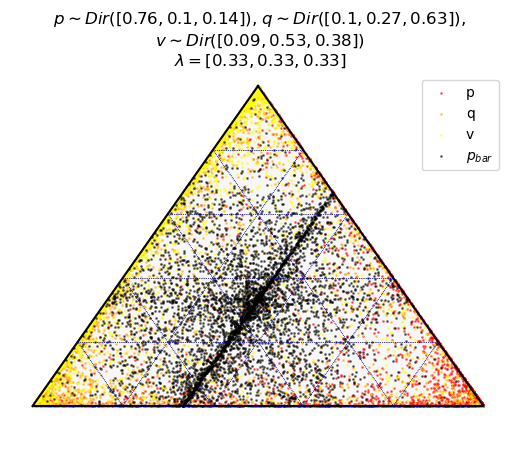

In [4]:
fig, tax = ternary.figure(scale=1)
tax.boundary(linewidth=1.5)

tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the default, essentially
tax.scatter([tuple(p_probs[i]) for i in range(len(p_probs))],  color='red', s= 1, alpha=0.5, label='p')
tax.scatter([tuple(q_probs[i]) for i in range(len(q_probs))],  color='orange', s= 1, alpha=0.5, label='q')
tax.scatter([tuple(v_probs[i]) for i in range(len(v_probs))],  color='yellow', s= 1, alpha=0.5, label='v')

# scatter p_bar 
tax.scatter([tuple(p_bar[i]) for i in range(len(p_bar))], marker='o', color='black', s= 1, alpha=0.5,
             label='$p_{bar}}$')

tax.legend()

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

plt.title(f" $p \sim Dir({list(np.round(m_1, 2))})$, $q \sim Dir({list(np.round(m_2, 2))})$, \n $v \sim Dir({list(np.round(m_3, 2))})$ \n $\lambda = {list(np.round(l_weights, 2))}$")
plt.show()

#### analyse correlation distance in $\lambda$ space <--> value of miscalibration statistic

In [5]:
res = run_distance_analysis(params=config_p_value_analysis, y_labels=y_labels, p_probs=P, l_weight=l_weights,
                             n_iter=N_ITERS, distance=euclidean)

Running analysis for test SKCEul2


100%|██████████| 2000/2000 [01:22<00:00, 24.13it/s]


Running analysis for test SKCEul


100%|██████████| 2000/2000 [01:25<00:00, 23.48it/s]


Running analysis for test HL5


100%|██████████| 2000/2000 [00:01<00:00, 1213.36it/s]


Running analysis for test HL10


100%|██████████| 2000/2000 [00:02<00:00, 911.26it/s]


Running analysis for test ECEconf5


100%|██████████| 2000/2000 [00:14<00:00, 137.68it/s]


Running analysis for test ECEconf10


100%|██████████| 2000/2000 [00:26<00:00, 75.17it/s]


Running analysis for test ECEclass5


100%|██████████| 2000/2000 [00:03<00:00, 580.68it/s]


Running analysis for test ECEclass10


100%|██████████| 2000/2000 [00:04<00:00, 417.22it/s]


plot both in scatterplot and heatmap analysis:

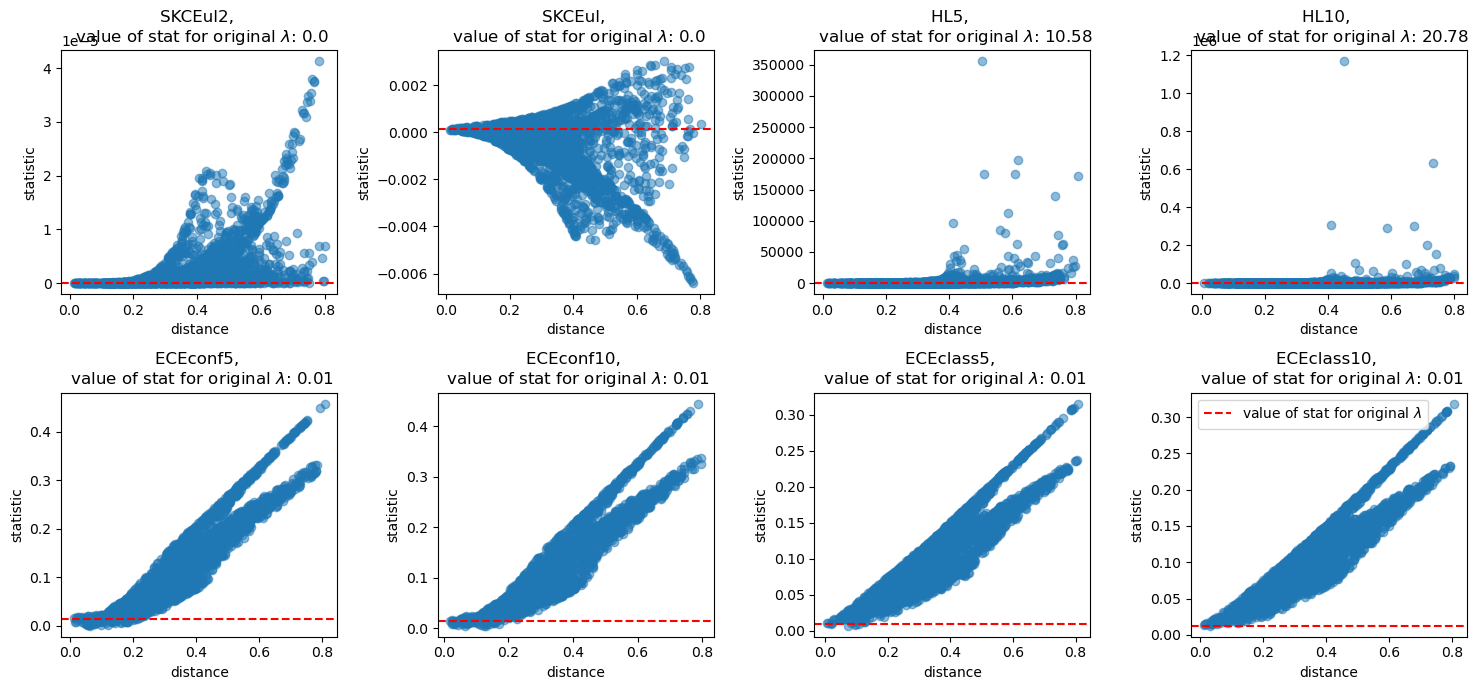

In [6]:
fig, ax = plt.subplots(2, 4, figsize=(15, 7))

for i, test in enumerate(config_p_value_analysis):

    # calculate value of statistic for real lambda
    real_val_stat = config_p_value_analysis[test]["params"]["obj"](p_bar, y_labels, config_p_value_analysis[test]["params"])


    ax[i // 4, i % 4].scatter(res[test]['dists'], res[test]['stats'], alpha=0.5)
    ax[i // 4, i % 4].set_xlabel("distance")
    ax[i // 4, i % 4].set_ylabel("statistic")
    ax[i // 4, i % 4].set_title(f"{test}, \n value of stat for original $\lambda$: {np.round(real_val_stat, 2)}")
    ax[i // 4, i % 4].axhline(real_val_stat, color="red", linestyle="--", label="value of stat for original $\lambda$")

plt.legend()
plt.tight_layout()

/Users/mirajuergens/Library/CloudStorage/OneDrive-UGent/Code/EnsembleCalibration/ensemblecalibration/calibration/plot_functions.py:107: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  norm = matplotlib.colors.SymLogNorm(linthresh=0.05))


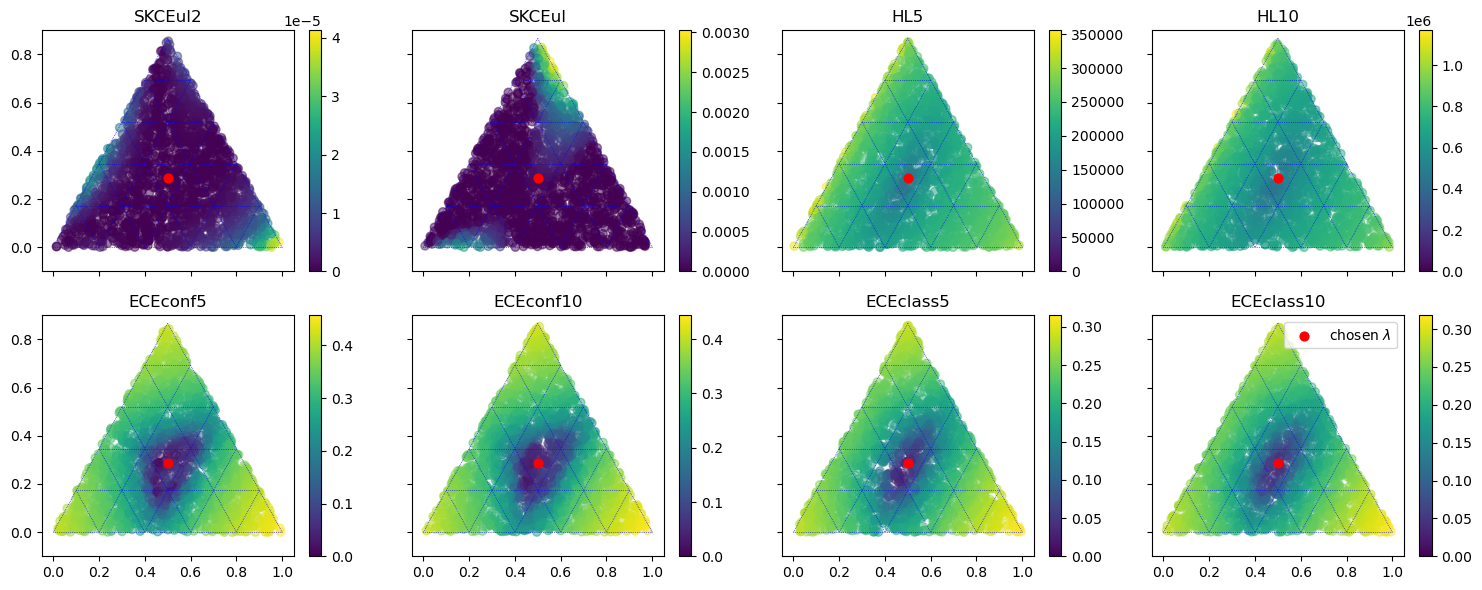

In [7]:
fig_heatmap_exp_0 = plot_heatmap_analysis(res=res, l_real=l_weights, params=config_p_value_analysis, 
                                          figsize=(15, 6))

### 2. experiment: sample prior means new for each instance and each ensemble member

sample predictions:

In [9]:
# for each ensemble member, sample the prior means from a dirichlet distribution for each instance
p_probs_2 = np.zeros((N_FEATURES, N_PREDICTORS, N_CLASSES))
for ens in range(N_PREDICTORS):
    for n in range(N_FEATURES):
        # sample prior means
        m = np.random.dirichlet([1/N_CLASSES]*N_CLASSES)

        # sample from  dirichlet distributions 
        p_probs_2[n, ens, :] = np.random.dirichlet(m, size=1)

# calculate p_bar, use lambda defined above
p_bar = calculate_pbar(l_weights, p_probs_2, reshape=False, n_dims=1)

# sample labels from multinomial distribution
y_labels_2 = np.apply_along_axis(multinomial_label_sampling, 1, p_bar)


plot predictions in the simplex:

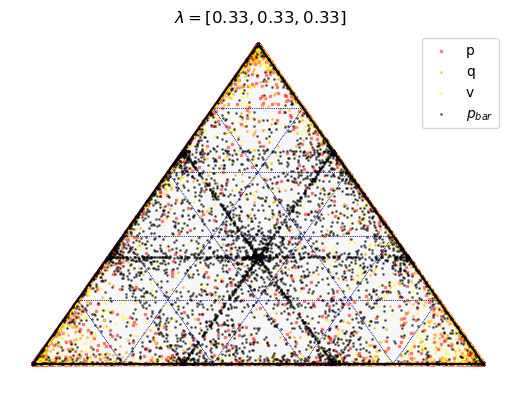

In [10]:
fig, tax = ternary.figure(scale=1)
tax.boundary(linewidth=1.5)

tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the default, essentially
tax.scatter([tuple(p_probs_2[i, 0, :]) for i in range(len(p_probs_2))], marker='s', color='red', s= 1, alpha=0.4, label='p')
tax.scatter([tuple(p_probs_2[i, 1, :]) for i in range(len(p_probs_2))], marker='D', color='orange', s= 1, alpha=0.5, label='q')
tax.scatter([tuple(p_probs_2[i, 2, :]) for i in range(len(p_probs_2))], marker='o', color='yellow', s= 1, alpha=0.5, label='v')

# scatter p_bar 
tax.scatter([tuple(p_bar[i]) for i in range(len(p_bar))], marker='o', color='black', s= 1, alpha=0.5, label='$p_{bar}}$')

tax.legend()

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

plt.title(f" $\lambda = {list(np.round(l_weights, 2))}$")
plt.show()

#### perform distance analysis


In [11]:
res = run_distance_analysis(params=config_p_value_analysis, y_labels=y_labels_2, p_probs=p_probs_2,
                            l_weight=l_weights, n_iter=N_ITERS, distance=euclidean)

Running analysis for test SKCEul2


100%|██████████| 2000/2000 [01:22<00:00, 24.25it/s]


Running analysis for test SKCEul


100%|██████████| 2000/2000 [01:23<00:00, 23.83it/s]


Running analysis for test HL5


100%|██████████| 2000/2000 [00:01<00:00, 1259.23it/s]


Running analysis for test HL10


100%|██████████| 2000/2000 [00:02<00:00, 959.27it/s]


Running analysis for test ECEconf5


100%|██████████| 2000/2000 [00:14<00:00, 138.88it/s]


Running analysis for test ECEconf10


100%|██████████| 2000/2000 [00:26<00:00, 75.59it/s]


Running analysis for test ECEclass5


100%|██████████| 2000/2000 [00:03<00:00, 553.14it/s]


Running analysis for test ECEclass10


100%|██████████| 2000/2000 [00:04<00:00, 405.53it/s]


#### plot results

scterplot:

No handles with labels found to put in legend.


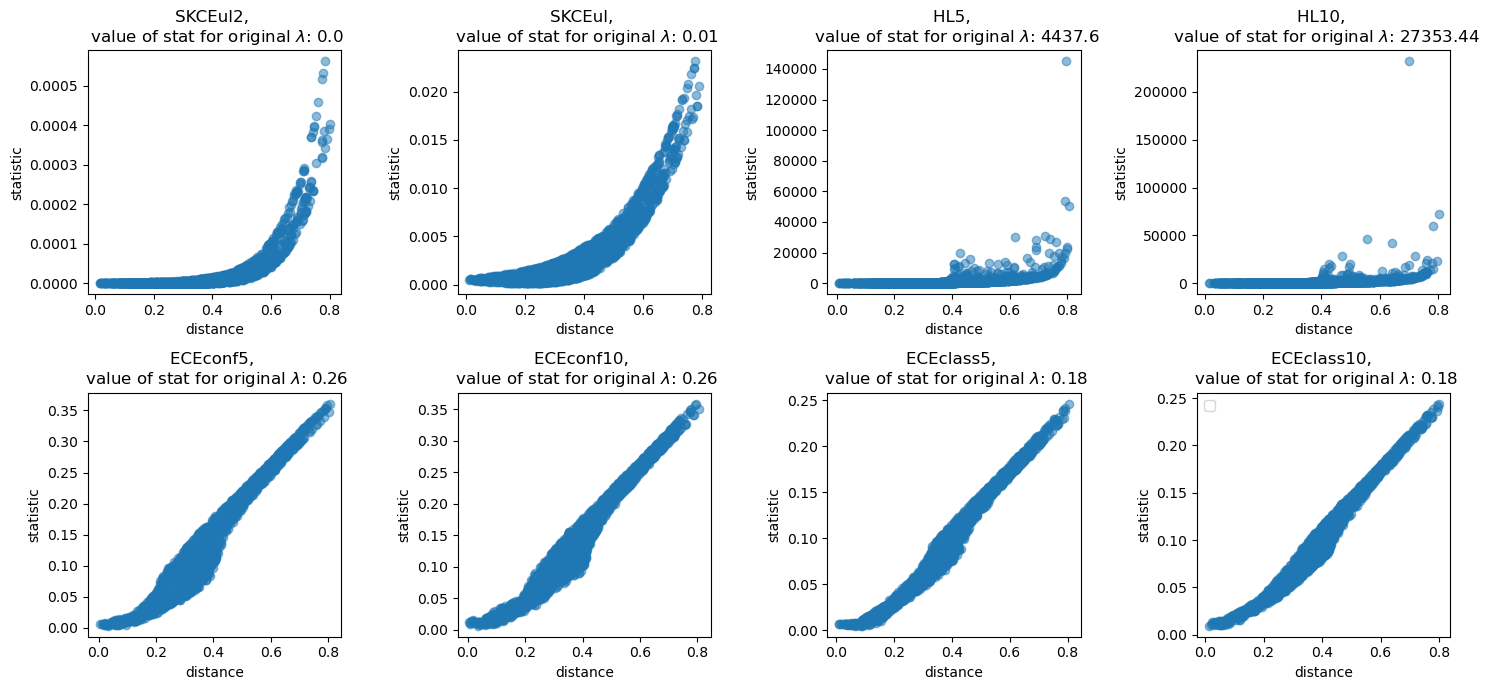

In [12]:
fig, ax = plt.subplots(2,  4, figsize=(15, 7))
scale = 30

for i, test in enumerate(config_p_value_analysis):

    # calculate value of statistic for real lambda
    real_val_stat = config_p_value_analysis[test]["params"]["obj"](p_bar, y_labels, config_p_value_analysis[test]["params"])


    ax[i // 4, i % 4].scatter(res[test]['dists'], res[test]['stats'], alpha=0.5)
    ax[i // 4, i % 4].set_xlabel("distance")
    ax[i // 4, i % 4].set_ylabel("statistic")
    ax[i // 4, i % 4].set_title(f"{test}, \n value of stat for original $\lambda$: {np.round(real_val_stat, 2)}")

plt.legend()
plt.tight_layout()

heatmap analysis:

/Users/mirajuergens/Library/CloudStorage/OneDrive-UGent/Code/EnsembleCalibration/ensemblecalibration/calibration/plot_functions.py:107: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  norm = matplotlib.colors.SymLogNorm(linthresh=0.05))


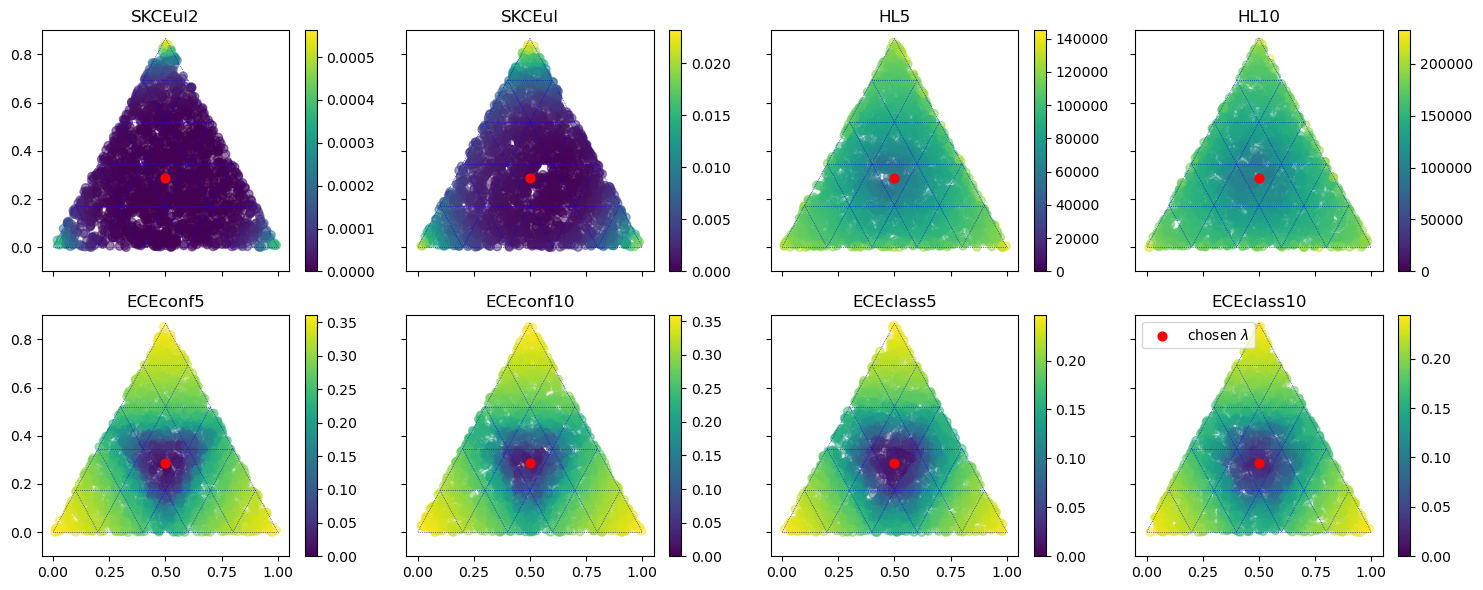

In [13]:
fig = plot_heatmap_analysis(res=res, params=config_p_value_analysis, l_real=l_weights)


### Setting 3: equal instance-dependent prior means for each member

In [5]:
# for each ensemble member, sample the prior means from a dirichlet distribution for each instance
p_probs = np.zeros((N_FEATURES, N_PREDICTORS, N_CLASSES))

for n in range(N_FEATURES):
    # sample prior means
    m = np.random.dirichlet([1/N_CLASSES]*N_CLASSES)

    # sample from  dirichlet distributions 
    p_probs[n, :, :] = np.random.dirichlet(m, size=N_PREDICTORS)


# calculate p_bar, use same lambda as above
p_bar = calculate_pbar(l_weights, p_probs, reshape=False, n_dims=1)

# sample labels from multinomial distribution
y_labels_3 = np.apply_along_axis(multinomial_label_sampling, 1, p_bar)

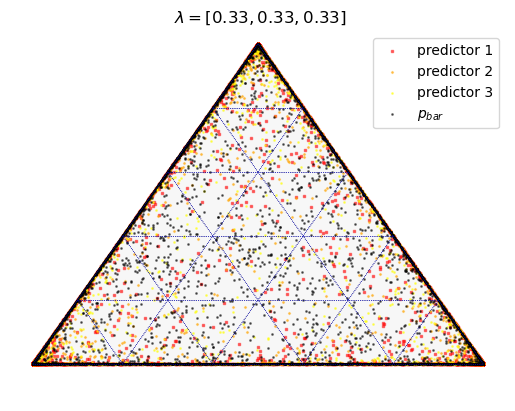

In [6]:
fig, tax = ternary.figure(scale=1)
tax.boundary(linewidth=1.5)

tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the default, essentially
tax.scatter([tuple(p_probs[i, 0, :]) for i in range(len(p_probs))], marker='s', color='red', s= 1, alpha=0.5, label='predictor 1')
tax.scatter([tuple(p_probs[i, 1, :]) for i in range(len(p_probs))], marker='D', color='orange', s= 1, alpha=0.5, label='predictor 2')
tax.scatter([tuple(p_probs[i, 2, :]) for i in range(len(p_probs))], marker='o', color='yellow', s= 1, alpha=0.5, label='predictor 3')

# scatter p_bar 
tax.scatter([tuple(p_bar[i]) for i in range(len(p_bar))], marker='o', color='black', s= 1, alpha=0.5, label='$p_{bar}}$')
#ax.scatter([tuple(q_bar[i]) 
# for i in range(len(q_bar))], marker='o', color='blue', s= 1, alpha=0.5, label='q_bar')


tax.legend()

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

plt.title(f" $\lambda = {list(np.round(l_weights, 2))}$")
plt.show()


In [7]:
res_3 = run_distance_analysis(params=config_p_value_analysis, y_labels=y_labels_3, p_probs=p_probs, 
                              l_weight=l_weights, n_iter=N_ITERS, distance=jensenshannon)

Running analysis for test SKCEul2


100%|██████████| 2000/2000 [01:24<00:00, 23.64it/s]


Running analysis for test SKCEul


100%|██████████| 2000/2000 [01:25<00:00, 23.31it/s]


Running analysis for test HL5


100%|██████████| 2000/2000 [00:01<00:00, 1268.81it/s]


Running analysis for test HL10


100%|██████████| 2000/2000 [00:02<00:00, 981.06it/s]


Running analysis for test ECEconf5


100%|██████████| 2000/2000 [00:14<00:00, 140.66it/s]


Running analysis for test ECEconf10


100%|██████████| 2000/2000 [00:25<00:00, 78.53it/s]


Running analysis for test ECEclass5


100%|██████████| 2000/2000 [00:03<00:00, 580.93it/s]


Running analysis for test ECEclass10


100%|██████████| 2000/2000 [00:04<00:00, 436.30it/s]


No handles with labels found to put in legend.


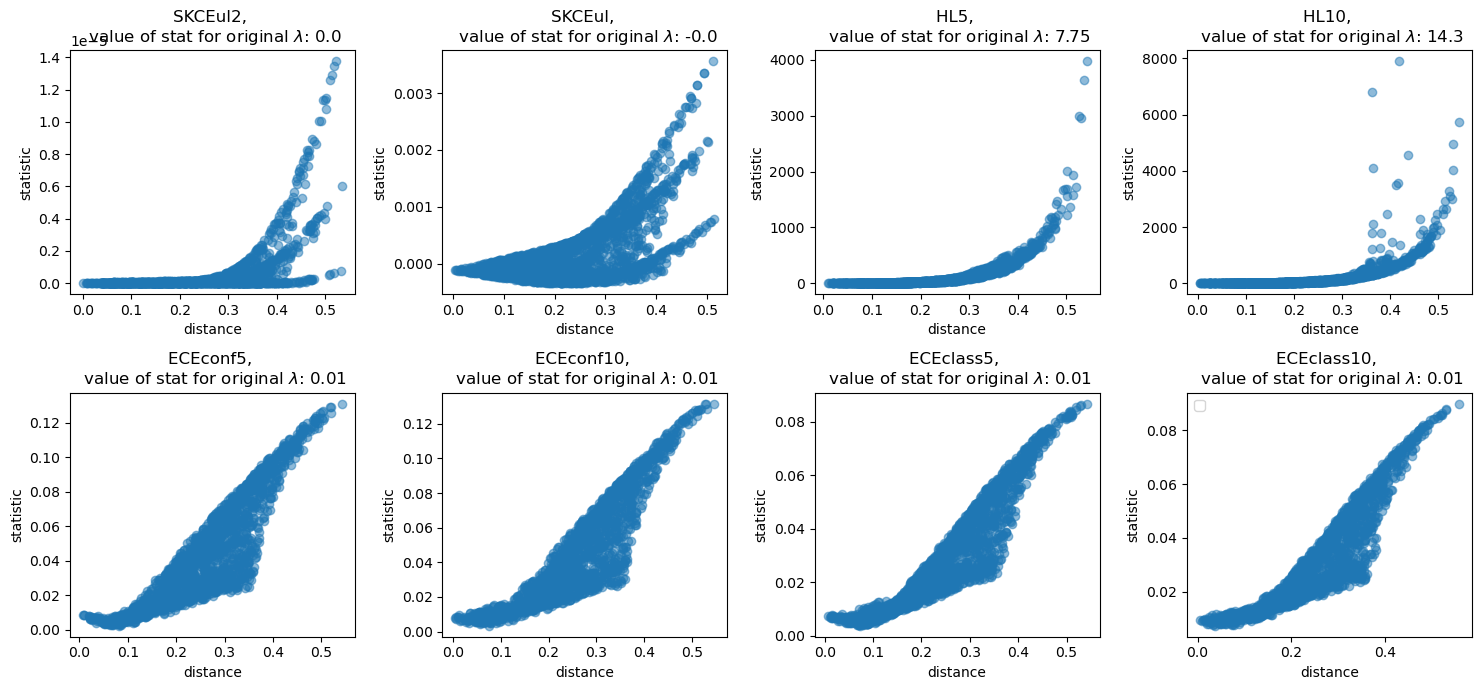

In [8]:
fig, ax = plt.subplots(2,  4, figsize=(15, 7))
scale = 30

for i, test in enumerate(config_p_value_analysis):

    # calculate value of statistic for real lambda
    real_val_stat = config_p_value_analysis[test]["params"]["obj"](p_bar, y_labels_3, config_p_value_analysis[test]["params"])


    ax[i // 4, i % 4].scatter(res_3[test]['dists'], res_3[test]['stats'], alpha=0.5)
    ax[i // 4, i % 4].set_xlabel("distance")
    ax[i // 4, i % 4].set_ylabel("statistic")
    ax[i // 4, i % 4].set_title(f"{test}, \n value of stat for original $\lambda$: {np.round(real_val_stat, 2)}")

plt.legend()
plt.tight_layout()

/Users/mirajuergens/Library/CloudStorage/OneDrive-UGent/Code/EnsembleCalibration/ensemblecalibration/calibration/plot_functions.py:107: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  norm = matplotlib.colors.SymLogNorm(linthresh=0.05))


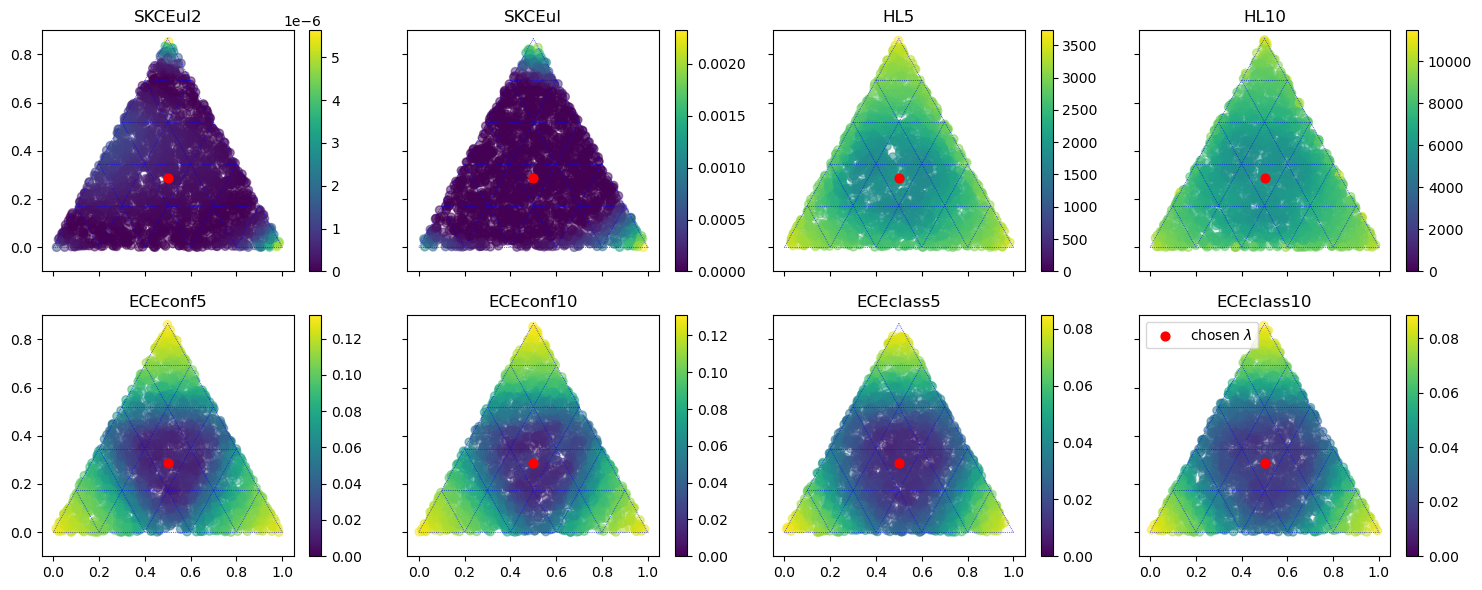

In [18]:
fig_heat_3 = plot_heatmap_analysis(res=res_3, params=config_p_value_analysis, l_real=l_weights)


### Do tests for instance-dependent weight vector

In [4]:
l_weights = np.random.dirichlet([1]*N_PREDICTORS, size=N_FEATURES)

p_probs = P

# calculate convex combination
p_bar_4 = calculate_pbar(l_weights, p_probs, reshape=True, n_dims=2)
# sample labels 
y_labels_4 = np.apply_along_axis(multinomial_label_sampling, 1, p_bar)

calculate minimum over all instance-depndent convex combinations using Cobyla Algorithm:

In [6]:
weights_calc = solve_cobyla2D(p_probs, y_labels_4, params=config_p_value_analysis["SKCEul"]["params"])

In [8]:
# calculate convex combination with calculated weights
p_bar_calc = calculate_pbar(weights_calc, p_probs, reshape=True, n_dims=2)


(5000, 3)

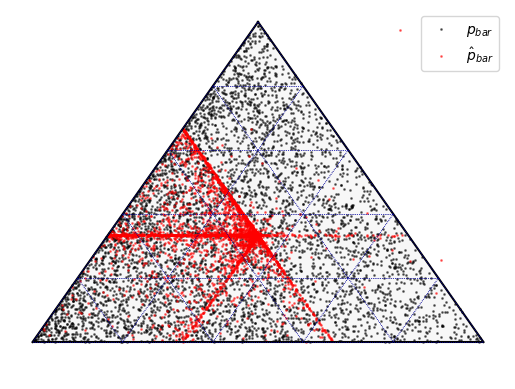

In [13]:
fig, tax = ternary.figure(scale=1)
tax.boundary(linewidth=1.5)

tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the default, essentially

# scatter p_bar 

tax.scatter([tuple(p_bar_4[i]) for i in range(len(p_bar_4))], marker='o', color='black', s= 1, alpha=0.5, label='$p_{bar}}$')
#
#tax.scatter([tuple(p_bar[i]) for i in range(len(p_bar))], marker='o', color='black', s= 1, alpha=0.5, label='$p_{bar}}$')
# scatter p_bar_calc
tax.scatter([tuple(p_bar_calc[i]) for i in range(len(p_bar_calc))], marker='o', color='red', s= 1, alpha=0.5, label='$\hat{p}_{bar}}$')

tax.legend()

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

plt.show()

In [14]:
weights_calc

array([1.33333333, 1.33333333, 1.33333333, ..., 0.33333333, 0.33333333,
       0.33333333])

Text(0.5, 1.0, ' $p \\sim Dir((1, 1, 1))$, $q \\sim Dir((0.1, 0.1, 0.1))$')

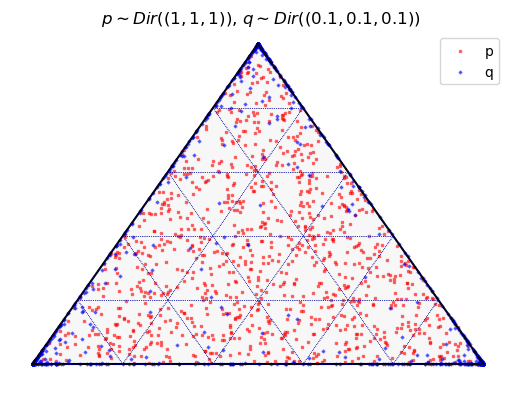

In [34]:
# ternary figure
fig, tax = ternary.figure(scale=1)
tax.boundary(linewidth=1.5)

tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the default, essentially
tax.scatter([tuple(p_probs[i]) for i in range(len(p_probs))], marker='s', color='red', s= 2, alpha=0.5, label='p')
tax.scatter([tuple(q_probs[i]) for i in range(len(q_probs))], marker='D', color='blue', s= 2, alpha=0.5, label='q')


tax.legend()

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

plt.title(f" $p \sim Dir({(u_p, u_p, u_p)})$, $q \sim Dir({(u_q, u_q, u_q)})$")


### analyse distances with respect to value of u

In [6]:
u = [0.01*n for n in range(1, 2000)]
dists_w1 = np.zeros(len(u))
dists_js = np.zeros(len(u))
dists_tv = np.zeros(len(u))
dists_mmd = np.zeros(len(u))
dists_kl = np.zeros(len(u))
dists_euc = np.zeros(len(u))

for i in tqdm(range(len(u))):
    u_q = u[i]
    p_probs = np.random.dirichlet(u_p*np.ones(3), size=1000)
    q_probs = np.random.dirichlet(u_q* np.ones(3), size=1000)
    dists_w1[i] = w1_distance(p_probs, q_probs)
    dists_js[i] = jensen_shannon_dist(p_probs, q_probs)
    dists_tv[i] = tv_distance(p_probs, q_probs)
    bw = optim_bw(p_probs, q_probs)
    dists_mmd[i] = mmd(p_probs, q_probs, bw=bw)
    dists_kl[i] = kl_divergence(p_probs, q_probs)
    dists_euc[i] = euclidean_distance(p_probs, q_probs)
    



100%|██████████| 1999/1999 [08:14<00:00,  4.05it/s]


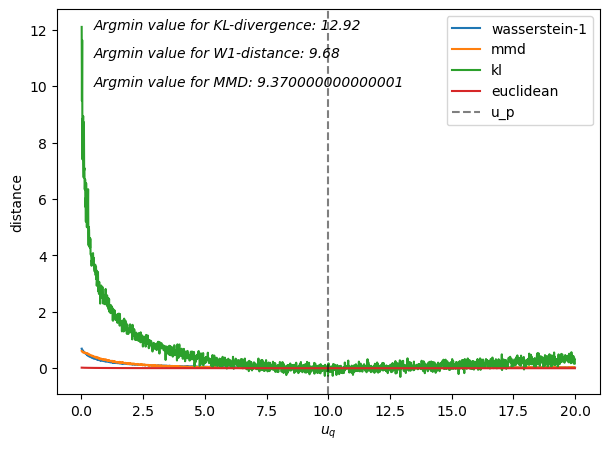

In [8]:
fig, ax = plt.subplots(figsize=(7,5))

plt.plot(u, dists_w1, label='wasserstein-1')
#plt.plot(u, dists_js, label='jensen-shannon')
#plt.plot(u, dists_tv, label='tv')
plt.plot(u, dists_mmd, label='mmd')
plt.plot(u, dists_kl, label='kl')
plt.plot(u, dists_euc, label='euclidean')
plt.xlabel('$u_q$')
plt.ylabel('distance')

ax.text(0.5, 12, f'Argmin value for KL-divergence: {u[np.argmin(dists_kl)]}', style='italic')
ax.text(0.5, 11, f'Argmin value for W1-distance: {u[np.argmin(dists_w1)]}', style='italic')
ax.text(0.5, 10, f'Argmin value for MMD: {u[np.argmin(dists_mmd)]}', style='italic')

ax.axvline(x=10, color='black', linestyle='--', alpha=0.5, label='u_p')


plt.legend()
plt.show()


 

In [31]:
print(f'Minimum value for KL-divergence: {u[np.argmin(dists_kl)]}')
print(f'Minimum value for W1-distance: {u[np.argmin(dists_w1)]}')
print(f'Minimum value for MMD discrepancy: {u[np.argmin(dists_mmd)]}')

Minimum value for KL-divergence: 9.09
Minimum value for W1-distance: 11.6
Minimum value for MMD discrepancy: 10.33


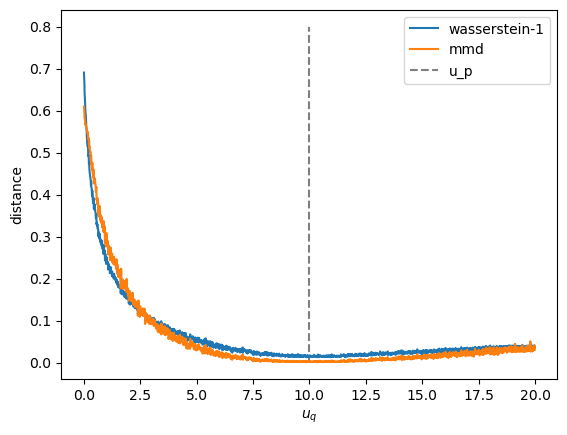

In [60]:
dists_w1

plt.plot(u, dists_w1, label='wasserstein-1')
#plt.plot(u, dists_js, label='jensen-shannon')
#plt.plot(u, dists_tv, label='tv')
plt.plot(u, dists_mmd, label='mmd')
#plt.plot(u, dists_kl, label='kl')
plt.vlines(10, 0, 0.8, color='black', linestyle='--', alpha=0.5, label='u_p')
plt.xlabel('$u_q$')
plt.ylabel('distance')
plt.legend()
plt.savefig('mmd_vs_w1.png', dpi=300)
plt.show()


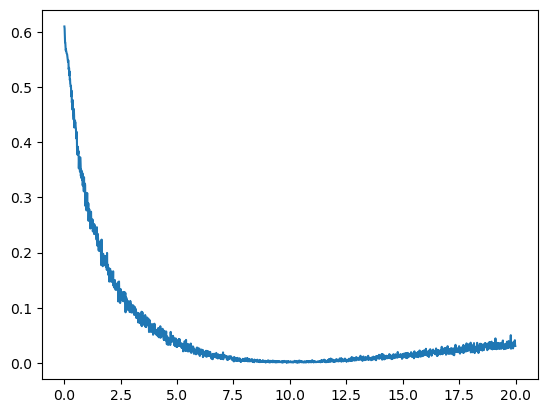

In [54]:
plt.plot(u, dists_mmd)

In [33]:
# evaluate experiments
N_INSTANCES = 5000
N_CLASSES = 3
N_ENS = 3
N_ITERS = 1000
params = config_p_value_analysis["ECEclass5"]["params"]

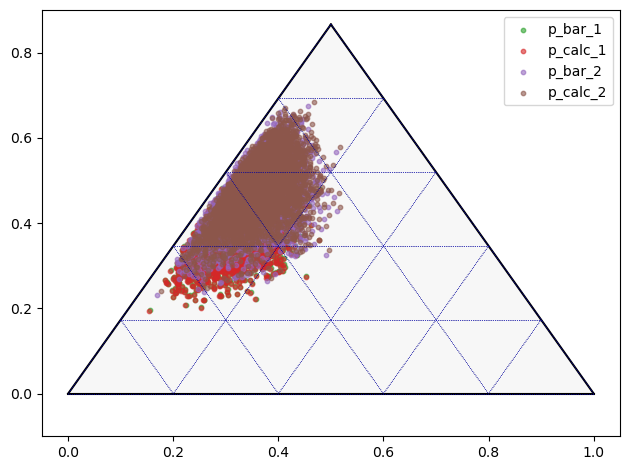

In [34]:
p_probs, y_labels, l_weights = new_experiment_h0(N_INSTANCES, N_ENS, 3, 0.1)
# sample 10 different convex combinations
p_bar = np.zeros((2, N_INSTANCES, N_CLASSES))
p_bar_calc = np.zeros((2, N_INSTANCES, N_CLASSES))
for i in range(2):
    l = np.random.dirichlet([1/3]*N_ENS)
    p_bar[i] = calculate_pbar(l, p_probs, reshape=False, n_dims=1)
    # sample labels from categorical distribution
    y_labels = np.apply_along_axis(multinomial_label_sampling, 1, p_bar[i])
    l_optim = solve_cobyla1D(p_probs, y_labels, params=params)
    p_bar_calc[i] = calculate_pbar(l_optim, p_probs, reshape=False, n_dims=1)


# ternary figure
fig, tax = ternary.figure(scale=1)
tax.boundary(linewidth=1.5)

tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the detault, essentially
#for ens in range(N_ENS):
 #   tax.scatter([tuple(p_probs[:,ens,:][i]) for i in range(N_INSTANCES)], marker='s', s= 10, alpha=0.2)

for i in range(len(p_bar)):
    tax.scatter([tuple(p_bar[i][j]) for j in range(N_INSTANCES)], marker='o', s= 10, alpha=0.6, label=f'p_bar_{i+1}')
    
    tax.scatter([tuple(p_bar_calc[i][j]) for j in range(N_INSTANCES)], marker='o', s= 10, alpha=0.6, label=f'p_calc_{i+1}')

tax.legend()
plt.tight_layout()



(array([120., 214., 218., 192., 150.,  64.,  25.,  10.,   5.,   2.]),
 array([1.08721478e-08, 1.12154092e-02, 2.24308076e-02, 3.36462060e-02,
        4.48616043e-02, 5.60770027e-02, 6.72924011e-02, 7.85077994e-02,
        8.97231978e-02, 1.00938596e-01, 1.12153995e-01]),
 <a list of 10 Patch objects>)

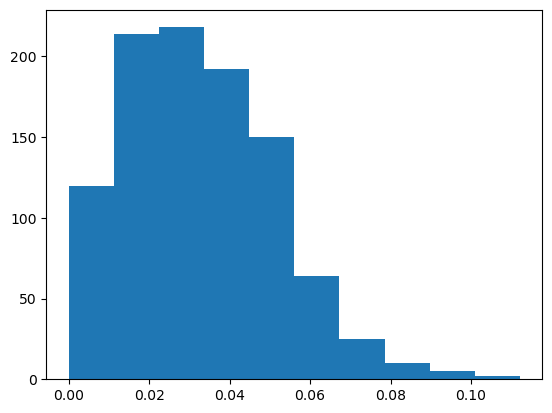

In [39]:
dists = np.zeros(N_INSTANCES)

for i in range(N_INSTANCES):
    dists[i] = jensenshannon(p_probs[i, 0, :], p_probs[i, 1, :])

dists

plt.hist(dists, bins=10)

#### Analysis on the accuracy of the calculated optimal convex combination

In [45]:
dists_cobyla = np.zeros(N_ITERS)
dists_nelder = np.zeros(N_ITERS)

for i in tqdm(range(N_ITERS)):
    l = np.random.dirichlet([1]*N_ENS)
    p_bar = calculate_pbar(l, p_probs, reshape=False, n_dims=1)
    # sample labels from categorical distribution
    y_labels = np.apply_along_axis(multinomial_label_sampling, 1, p_bar)
    l_optim_cobyla = solve_cobyla1D(p_probs, y_labels, params=params)
    l_optim_nelder = solve_neldermead1D(p_probs, y_labels, params=params)
    p_bar_calc = calculate_pbar(l_optim, p_probs, reshape=False, n_dims=1)
    dists_cobyla[i] = jensenshannon(l, l_optim)
    dists_nelder[i] = jensenshannon(l, l_optim_nelder)




  0%|          | 0/1000 [00:00<?, ?it/s]


TypeError: confece_obj() takes 3 positional arguments but 4 were given

(array([ 81.,  97., 114., 106.,  79.,  88.,  84.,  74.,  72.,  54.,  45.,
         30.,  29.,  15.,  10.,   4.,   8.,   4.,   4.,   2.]),
 array([0.        , 0.03620079, 0.07240158, 0.10860237, 0.14480316,
        0.18100395, 0.21720474, 0.25340553, 0.28960632, 0.32580711,
        0.3620079 , 0.39820869, 0.43440948, 0.47061027, 0.50681106,
        0.54301185, 0.57921264, 0.61541344, 0.65161423, 0.68781502,
        0.72401581]),
 <a list of 20 Patch objects>)

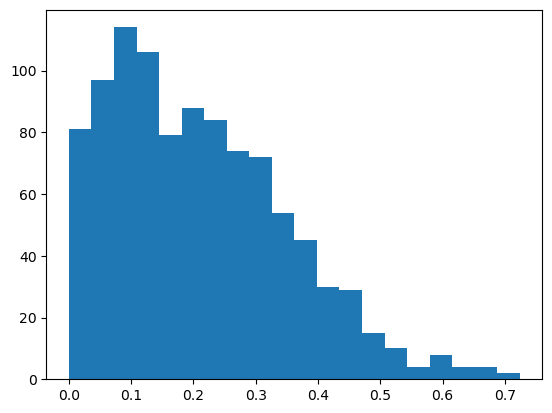

In [43]:
dists[dists == float('inf')] = 0.0
plt.hist(dists, bins=20)

### Analysis of the distribution of test statistics
sample randomly predictors from the convex hull, then perform statisstical boostrapping test. Compare value
of test statistc (miscalibration estimate) for the bootstrappping samples (wherer labels are generated under
the null hypothesis) with the value for the dataset.

In [22]:
# define test parameters
N_FEATURES = 100
N_ENS = 10
N_CLASSES = 10
U_DIR = 0.01


#### test for SKCEul under the null hypothesis:
generate probabilistic predictions of classifiers,
sample a random convex combination of them 
from whose predictions the labels are then sampled from (such that this convex comb is calibrated) 

In [23]:
p_probs, y_labels, weights_l = experiment_h0(N=N_FEATURES, M=N_ENS, K=N_CLASSES, u=U_DIR, 
                                             output_weights=True, l_prior=10)

stats, stats_h0, p_vals, true_stat = npbe_test_v3_p_values(p_probs=p_probs, y_labels=y_labels, 
                                                params=config_p_value_analysis["SKCEul"]["params"],
                                                weights_l=weights_l)

  1%|          | 1/100 [00:20<33:28, 20.28s/it]


KeyboardInterrupt: 

plot in histograms 

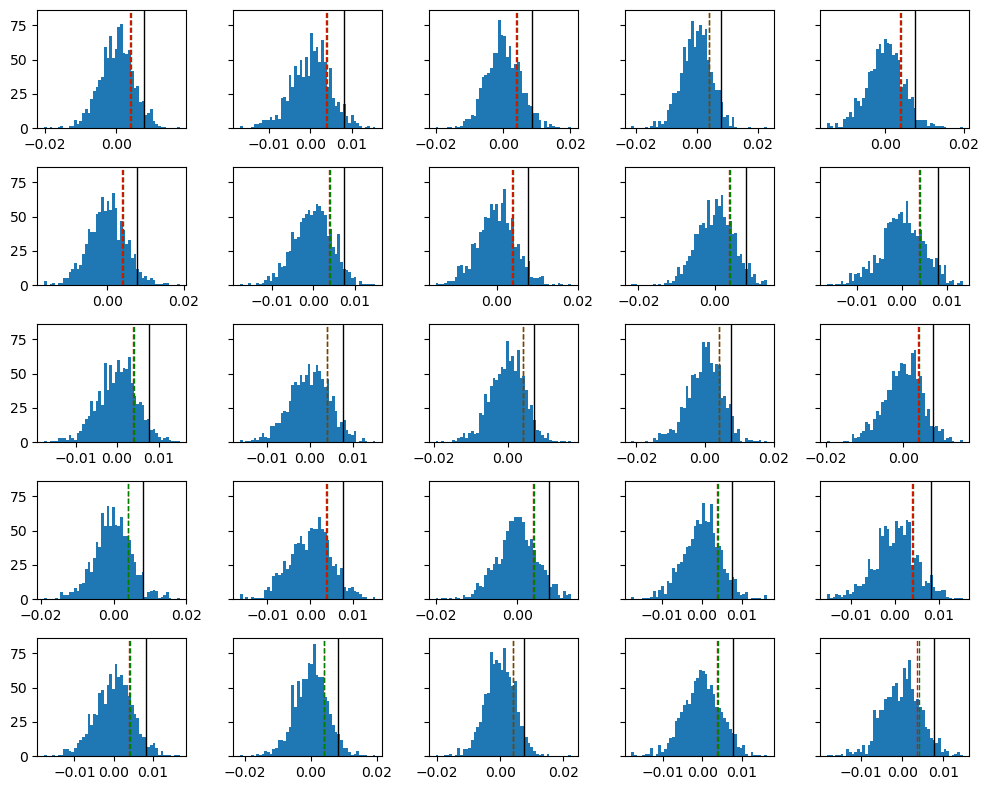

In [ ]:
fig, ax = plt.subplots(5,5, figsize=(10,8), sharey=True)
count = 0
for i in range(5):
    for j in range(5):
        ax[i,j].hist(stats_h0[count, :], bins=50)
        ax[i,j].axvline(x=stats[count], ymin=0, color='r', linestyle='--', linewidth=1)
        # calculate 95 % quantile
        q = np.quantile(stats_h0[count, :], 0.95)
        ax[i, j].axvline(x=q, ymin=0, color='black', linewidth=1)
        ax[i,j].axvline(x=true_stat, color='g', linestyle='--', linewidth=1)
        count +=1
plt.tight_layout()

plot p values with respect to statistic of miscalibration measure in a scatter plot

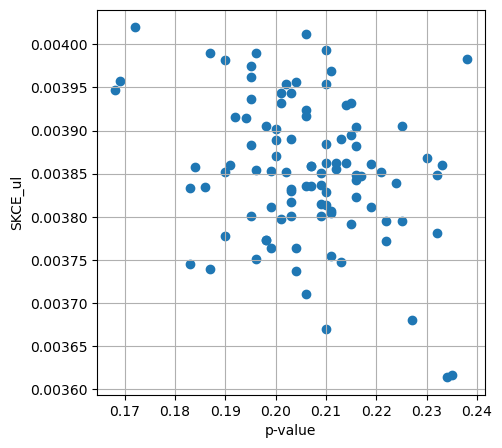

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(p_vals, stats)
ax.set_xlabel("p-value")
ax.set_ylabel("SKCE_ul")
plt.grid()

#### test for SKCEul under the alternative hypothesis: 

#### setting S3:

In [ ]:
p_probs, y_labels= experiment_h1(N=N_FEATURES, M=N_ENS, K=N_CLASSES, u=U_DIR, random=True)

stats, stats_h0, p_vals = npbe_test_v3_p_values(p_probs=p_probs, y_labels=y_labels, 
                                                params=config_p_value_analysis["SKCEul"]["params"])

100%|██████████| 100/100 [15:34<00:00,  9.34s/it]


plot

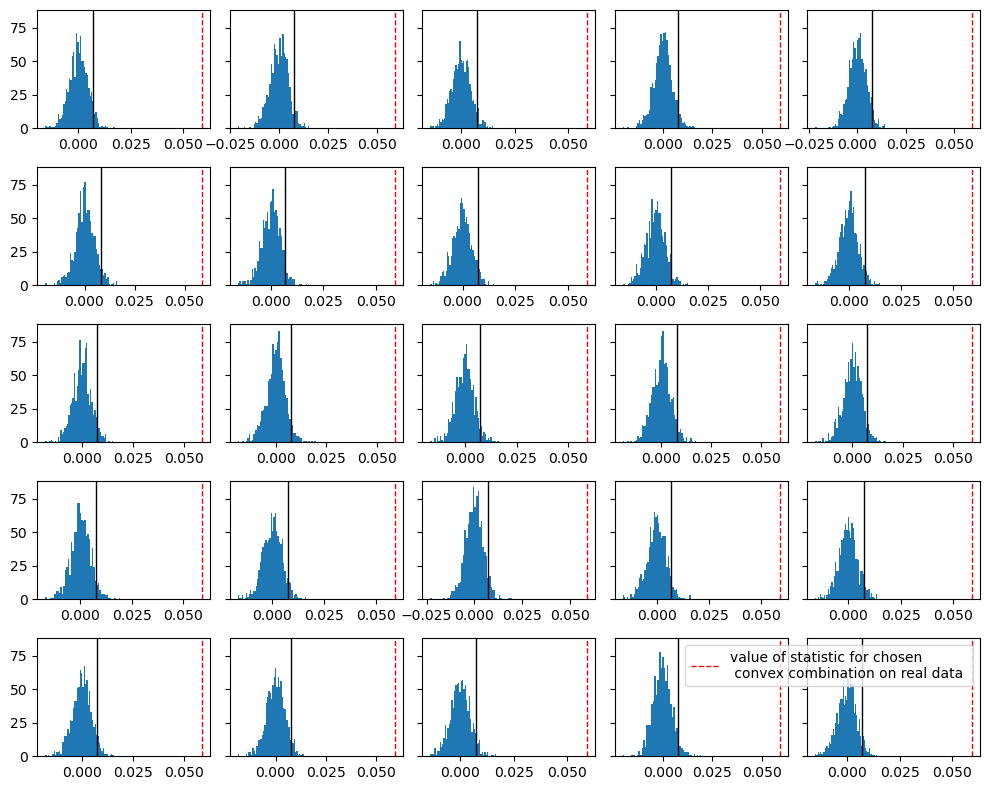

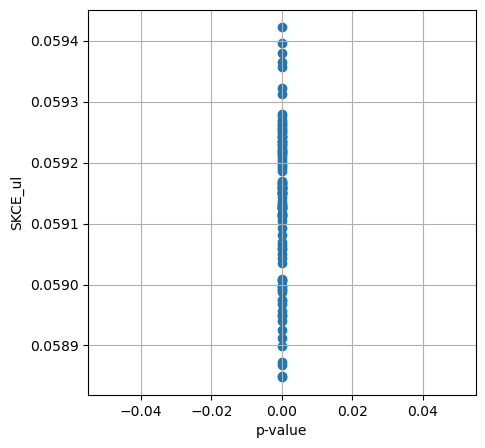

In [ ]:
fig, ax = plt.subplots(5,5, figsize=(10,8), sharey=True)
count = 0
for i in range(5):
    for j in range(5):
        ax[i,j].hist(stats_h0[count, :], bins=50)
        ax[i,j].axvline(x=stats[count], ymin=0, color='r', linestyle='--', linewidth=1, 
                        label="value of statistic for chosen \n convex combination on real data ")
        # calculate 95 % quantile
        q = np.quantile(stats_h0[count, :], 0.95)
        ax[i, j].axvline(x=q, ymin=0, color='black', linewidth=1)
        #ax[i,j].axvline(x=true_stat, color='g', linestyle='--', linewidth=1)
        count +=1
plt.tight_layout()
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(p_vals, stats)
ax.set_xlabel("p-value")
ax.set_ylabel("SKCE_ul")
plt.grid()

#### setting S2:

In [ ]:
p_probs, y_labels= experiment_h1(N=N_FEATURES, M=N_ENS, K=N_CLASSES, u=U_DIR, random=False)

stats, stats_h0, p_vals = npbe_test_v3_p_values(p_probs=p_probs, y_labels=y_labels, 
                                                params=config_p_value_analysis["SKCEul"]["params"])

100%|██████████| 100/100 [15:07<00:00,  9.07s/it]


plot:

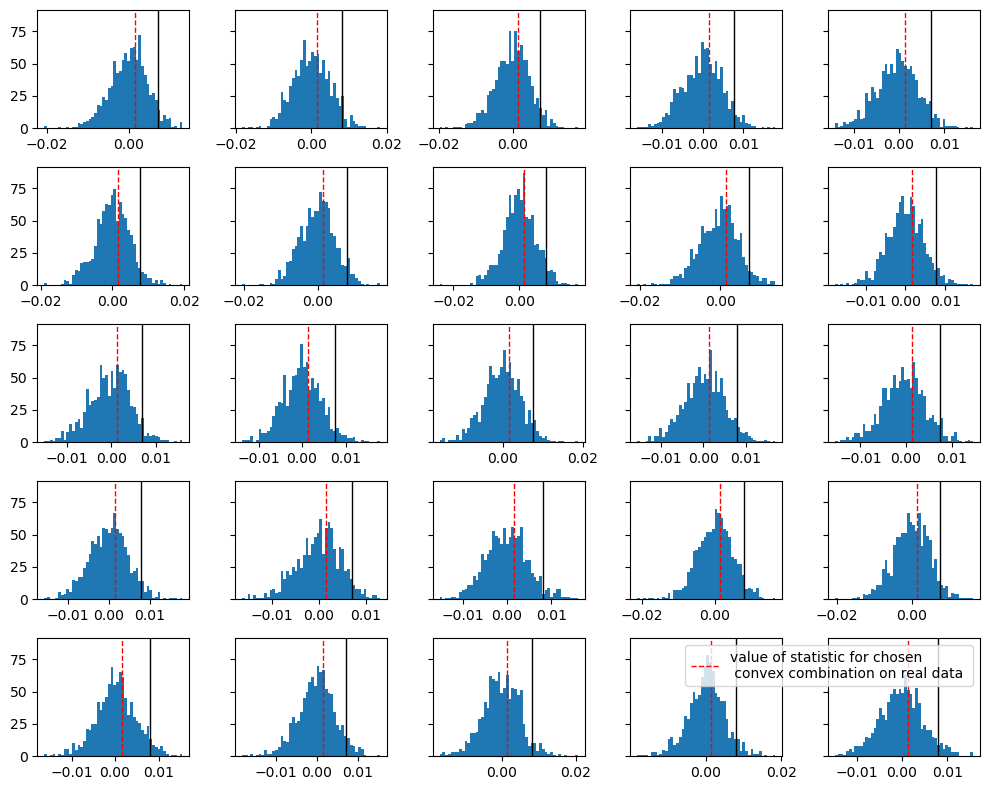

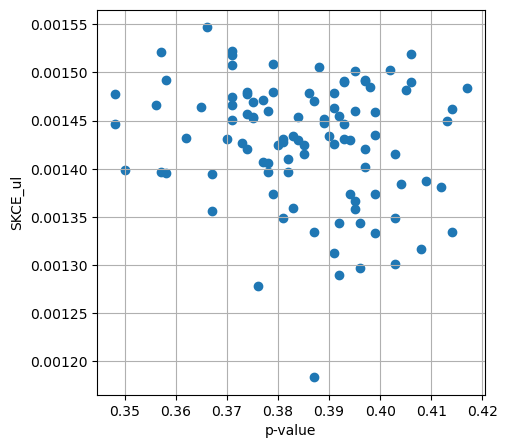

In [ ]:
fig, ax = plt.subplots(5,5, figsize=(10,8), sharey=True)
count = 10
for i in range(5):
    for j in range(5):
        ax[i,j].hist(stats_h0[count, :], bins=50)
        ax[i,j].axvline(x=stats[count], ymin=0, color='r', linestyle='--', linewidth=1, 
                        label="value of statistic for chosen \n convex combination on real data ")
        # calculate 95 % quantile
        q = np.quantile(stats_h0[count, :], 0.95)
        ax[i, j].axvline(x=q, ymin=0, color='black', linewidth=1)
        #ax[i,j].axvline(x=true_stat, color='g', linestyle='--', linewidth=1)
        count +=1
plt.tight_layout()
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(p_vals, stats)
ax.set_xlabel("p-value")
ax.set_ylabel("SKCE_ul")
plt.grid()

In [ ]:
avg_stats_h0 = np.mean(stats_h0, axis=0)
avg_stats = np.mean(stats)

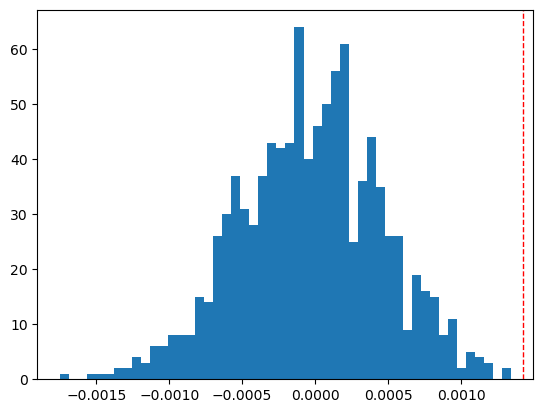

In [ ]:
plt.hist(avg_stats_h0, bins=50)
plt.axvline(avg_stats, color='r', linestyle='--', linewidth=1)

### TODO: test for squared SKCEul!!

1. under null hypothesis

In [ ]:
p_probs, y_labels, weights_l = experiment_h0(N=N_FEATURES, M=N_ENS, K=N_CLASSES, u=U_DIR, l_prior=1,
                                            output_weights=True)

stats, stats_h0, p_vals = npbe_test_v3_p_values(p_probs=p_probs, y_labels=y_labels, 
                                                params=config_p_value_analysis["SKCEul2"]["params"])

100%|██████████| 100/100 [15:25<00:00,  9.26s/it]


plot

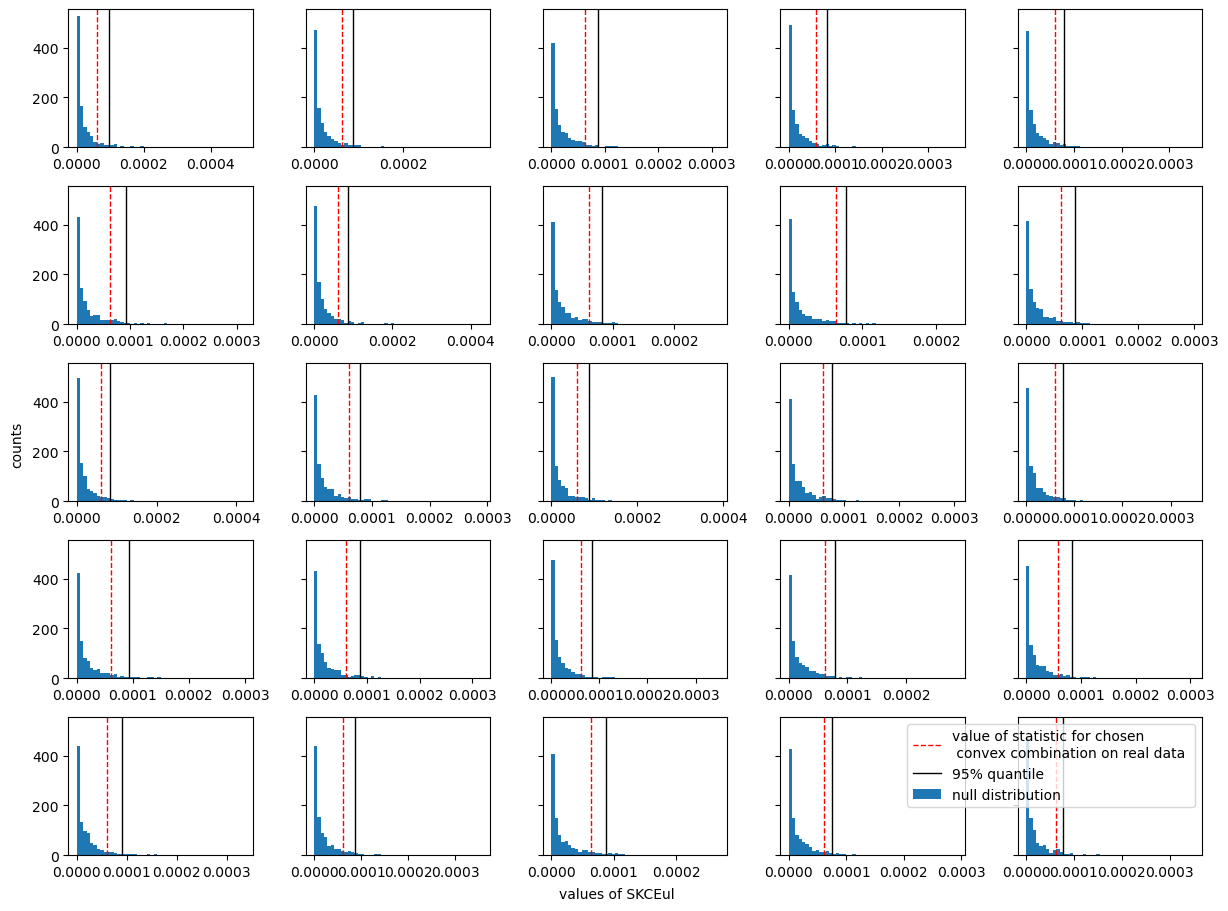

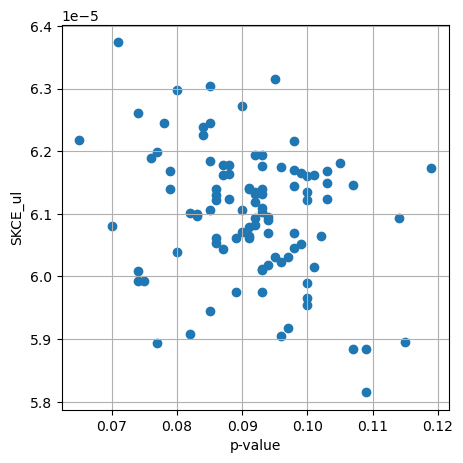

In [ ]:
fig, ax = plt.subplots(5,5, figsize=(12,9), sharey=True)
count = 0
for i in range(5):
    for j in range(5):
        ax[i,j].hist(stats_h0[count, :], bins=50, label="null distribution")
        ax[i,j].axvline(x=stats[count], ymin=0, color='r', linestyle='--', linewidth=1,
                        label="value of statistic for chosen \n convex combination on real data ")
        # calculate 95 % quantile
        q = np.quantile(stats_h0[count, :], 0.95)
        ax[i, j].axvline(x=q, ymin=0, color='black', linewidth=1, label="95% quantile")
       # ax[i,j].axvline(x=true_stat, color='g', linestyle='--', linewidth=1)
        count +=1
plt.tight_layout()
plt.legend()
fig.text(0.5, 0.0, 'values of SKCEul', ha='center', va='center')
fig.text(0.0, 0.5, 'counts', ha='center', va='center', rotation='vertical')
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(p_vals, stats)
ax.set_xlabel("p-value")
ax.set_ylabel("SKCE_ul")
plt.grid()

analyse distribution of values of the test statistic for the real data for each convex combination

In [ ]:
true_stat = config_p_value_analysis["SKCEul2"]["params"]["obj_lambda"](weights_l=weights_l,
                                                                                 p_probs=p_probs, 
                                                                            y_labels=y_labels,
                                                                            params=config_p_value_analysis["SKCEul2"]["params"])

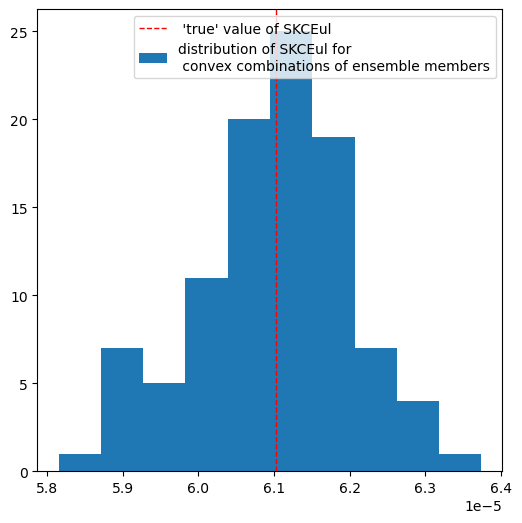

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.axvline(x=true_stat, color='r', linestyle='--', linewidth=1, label=" 'true' value of SKCEul")
ax.hist(stats, bins=10, label="distribution of SKCEul for \n convex combinations of ensemble members")
plt.legend()


under alternative:

In [ ]:
p_probs, y_labels = experiment_h1(N=N_FEATURES, M=N_ENS, K=N_CLASSES, u=U_DIR)

stats, stats_h0, p_vals = npbe_test_v3_p_values(p_probs=p_probs, y_labels=y_labels, 
                                                params=config_p_value_analysis["SKCEul2"]["params"])

100%|██████████| 100/100 [15:12<00:00,  9.12s/it]


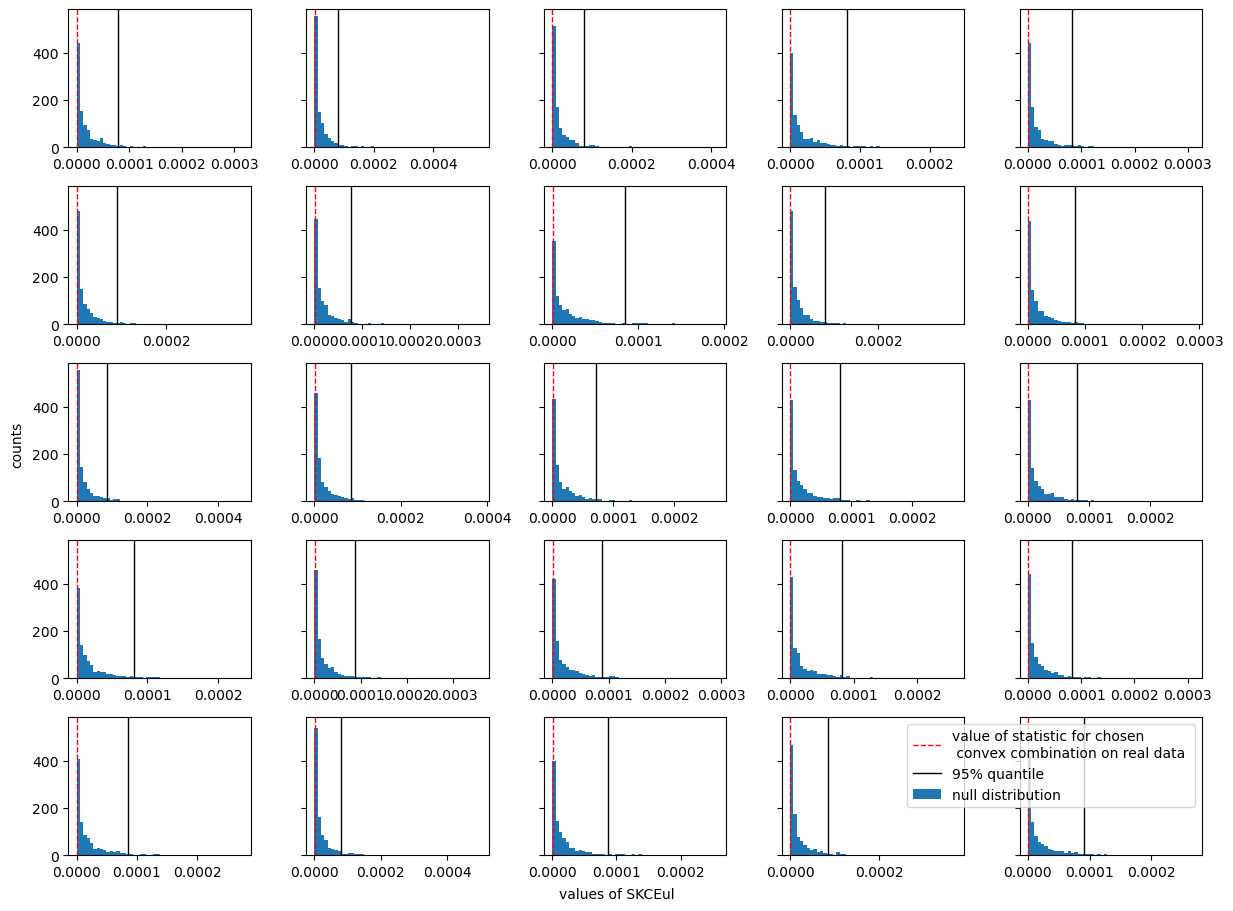

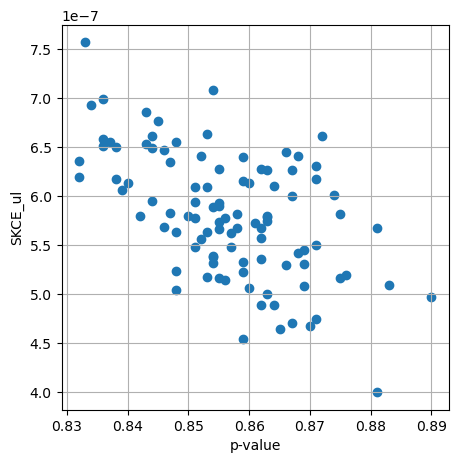

In [ ]:
fig, ax = plt.subplots(5,5, figsize=(12,9), sharey=True)
count = 0
for i in range(5):
    for j in range(5):
        ax[i,j].hist(stats_h0[count, :], bins=50, label="null distribution")
        ax[i,j].axvline(x=stats[count], ymin=0, color='r', linestyle='--', linewidth=1,
                        label="value of statistic for chosen \n convex combination on real data ")
        # calculate 95 % quantile
        q = np.quantile(stats_h0[count, :], 0.95)
        ax[i, j].axvline(x=q, ymin=0, color='black', linewidth=1, label="95% quantile")
       # ax[i,j].axvline(x=true_stat, color='g', linestyle='--', linewidth=1)
        count +=1
plt.tight_layout()
plt.legend()
fig.text(0.5, 0.0, 'values of SKCEul', ha='center', va='center')
fig.text(0.0, 0.5, 'counts', ha='center', va='center', rotation='vertical')
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(p_vals, stats)
ax.set_xlabel("p-value")
ax.set_ylabel("SKCE_ul")
plt.grid()

In [ ]:
p_probs, y_labels = experiment_h1(N=N_FEATURES, M=N_ENS, K=N_CLASSES, u=U_DIR, random=True)

stats, stats_h0, p_vals = npbe_test_v3_p_values(p_probs=p_probs, y_labels=y_labels, 
                                                params=config_p_value_analysis["SKCEul2"]["params"])

100%|██████████| 100/100 [15:06<00:00,  9.07s/it]


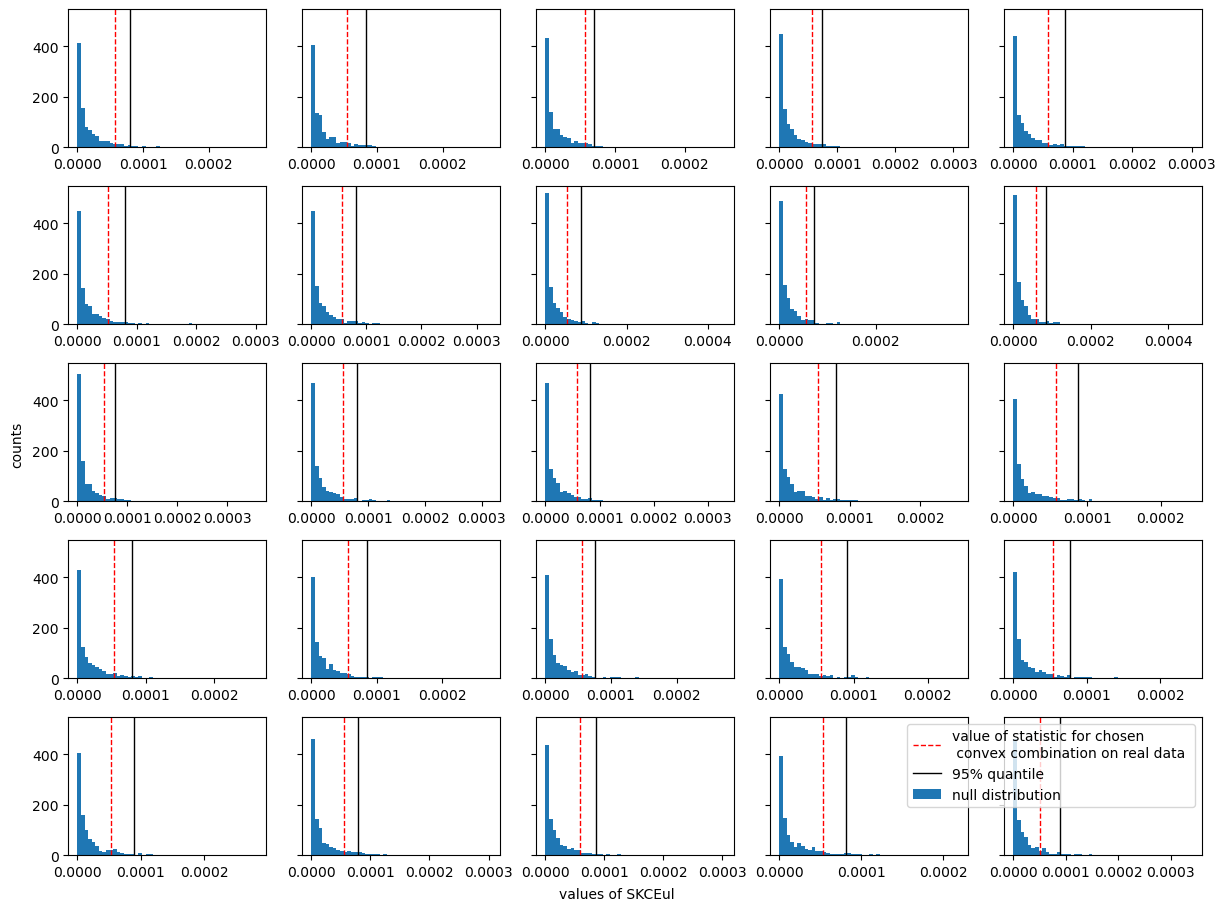

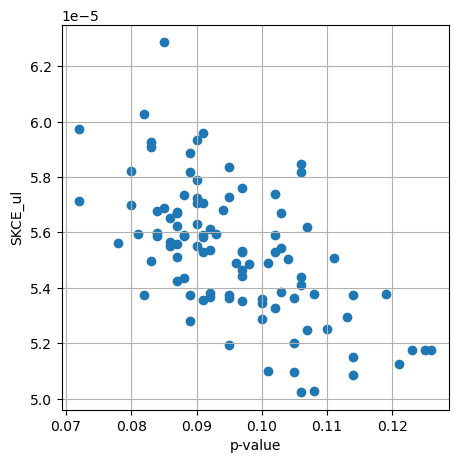

In [ ]:
fig, ax = plt.subplots(5,5, figsize=(12,9), sharey=True)
count = 10
for i in range(5):
    for j in range(5):
        ax[i,j].hist(stats_h0[count, :], bins=50, label="null distribution")
        ax[i,j].axvline(x=stats[count], ymin=0, color='r', linestyle='--', linewidth=1,
                        label="value of statistic for chosen \n convex combination on real data ")
        # calculate 95 % quantile
        q = np.quantile(stats_h0[count, :], 0.95)
        ax[i, j].axvline(x=q, ymin=0, color='black', linewidth=1, label="95% quantile")
       # ax[i,j].axvline(x=true_stat, color='g', linestyle='--', linewidth=1)
        count +=1
plt.tight_layout()
plt.legend()
fig.text(0.5, 0.0, 'values of SKCEul', ha='center', va='center')
fig.text(0.0, 0.5, 'counts', ha='center', va='center', rotation='vertical')
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(p_vals, stats)
ax.set_xlabel("p-value")
ax.set_ylabel("SKCE_ul")
plt.grid()

Hosmer-Lemeshow:

In [ ]:
p_probs, y_labels = experiment_h0(N=N_FEATURES, M=N_ENS, K=N_CLASSES, u=U_DIR)

stats, stats_h0, p_vals = npbe_test_v3_p_values(p_probs=p_probs, y_labels=y_labels, 
                                                params=config_p_value_analysis["HL10"]["params"])

  0%|          | 0/100 [00:00<?, ?it/s]/Users/mirajuergens/Library/CloudStorage/OneDrive-UGent/Code/EnsembleCalibration/ensemblecalibration/calibration/calibration_estimates/hl.py:60: RuntimeWarning: invalid value encountered in double_scalars
  dev_bk = ((o_bk-p_bk)**2)/p_bk
 31%|███       | 31/100 [04:58<11:06,  9.67s/it]/Users/mirajuergens/Library/CloudStorage/OneDrive-UGent/Code/EnsembleCalibration/ensemblecalibration/calibration/calibration_estimates/hl.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  dev_bk = ((o_bk-p_bk)**2)/p_bk
100%|██████████| 100/100 [16:03<00:00,  9.64s/it]


In [ ]:
stats

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

## TODO!!
- analyze minimization for SKCE
- discrepancy minimum value of statistic vs "true" value of statistic for ECE, SKCEul, HL
- analysis for HL

test for ECE under null hypothesis:

In [ ]:
p_probs, y_labels = experiment_h0(N=N_FEATURES, M=N_ENS, K=N_CLASSES, u=U_DIR, l_prior=1)

In [ ]:
stats, stats_h0, p_vals = npbe_test_v3_p_values(p_probs=p_probs,y_labels=y_labels, params=config_p_value_analysis["ECEclass10"]["params"])

  0%|          | 0/100 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
p_vals

array([0.349, 0.345, 0.347, 0.362, 0.27 , 0.214, 0.269, 0.298, 0.311,
       0.298, 0.24 , 0.265, 0.276, 0.335, 0.305, 0.313, 0.319, 0.352,
       0.341, 0.173, 0.317, 0.37 , 0.201, 0.413, 0.331, 0.317, 0.311,
       0.365, 0.289, 0.266, 0.291, 0.268, 0.297, 0.374, 0.341, 0.444,
       0.273, 0.236, 0.378, 0.29 , 0.269, 0.238, 0.371, 0.317, 0.241,
       0.277, 0.244, 0.246, 0.359, 0.332, 0.288, 0.292, 0.314, 0.319,
       0.201, 0.176, 0.181, 0.209, 0.374, 0.247, 0.235, 0.354, 0.287,
       0.333, 0.299, 0.181, 0.314, 0.221, 0.366, 0.383, 0.332, 0.288,
       0.304, 0.179, 0.295, 0.274, 0.275, 0.386, 0.382, 0.284, 0.33 ,
       0.331, 0.336, 0.264, 0.238, 0.362, 0.168, 0.378, 0.294, 0.209,
       0.332, 0.306, 0.237, 0.359, 0.277, 0.276, 0.261, 0.381, 0.152,
       0.307])

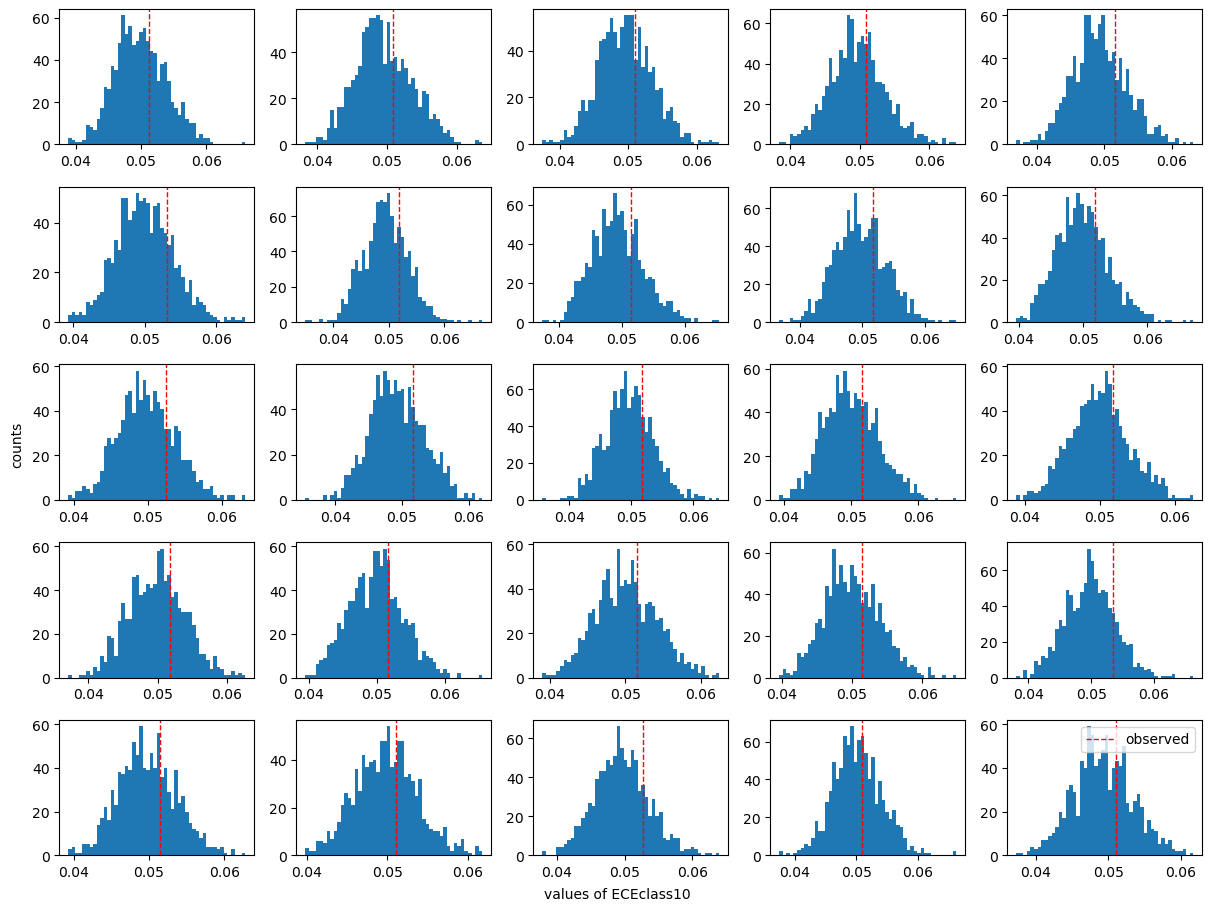

In [ ]:
fig, ax = plt.subplots(5,5, figsize=(12,9),)
count = 0
for i in range(5):
    for j in range(5):
        ax[i,j].hist(stats_h0[count, :], bins=50)
        ax[i,j].axvline(x=stats[count], ymin=0, color='r', linestyle='--', linewidth=1, label="observed")
        count +=1
fig.text(0.5, 0.0, 'values of ECEclass10', ha='center', va='center')
fig.text(0.0, 0.5, 'counts', ha='center', va='center', rotation='vertical')
plt.tight_layout()
plt.legend()

plot the p values in dependency of the value of the statistic (miscalibration measure) in a scatter plot

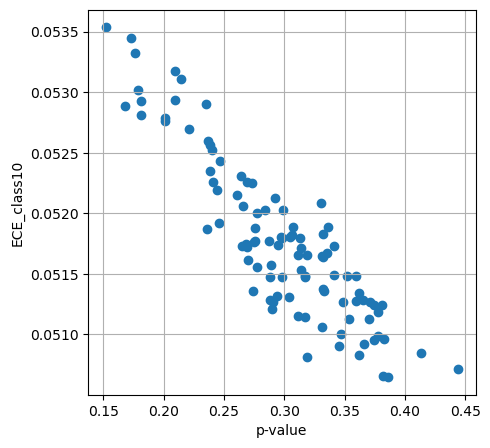

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(p_vals, stats)
ax.set_xlabel("p-value")
ax.set_ylabel("ECE_class10")
plt.grid()

test for ECE under alternative hypothesis:

In [ ]:
p_probs, y_labels = experiment_h1(N=N_FEATURES, M=N_ENS, K=N_CLASSES, u=U_DIR)

In [ ]:
stats, stats_h0, p_vals = npbe_test_v3_p_values(p_probs=p_probs,y_labels=y_labels,
                                                params=config_p_value_analysis["ECEclass10"]["params"])

100%|██████████| 100/100 [18:00<00:00, 10.80s/it]


In [ ]:
stats

array([0.056839, 0.055487, 0.055306, 0.056648, 0.054754, 0.055973,
       0.054838, 0.056609, 0.055962, 0.05574 , 0.05689 , 0.054639,
       0.058135, 0.055788, 0.056927, 0.056105, 0.055302, 0.056748,
       0.055345, 0.056639, 0.055299, 0.055964, 0.055393, 0.055271,
       0.055563, 0.055161, 0.055364, 0.05661 , 0.056635, 0.055455,
       0.056195, 0.055271, 0.056809, 0.055358, 0.054625, 0.055915,
       0.056021, 0.055356, 0.05514 , 0.055298, 0.056895, 0.054371,
       0.056285, 0.054556, 0.054486, 0.055912, 0.056577, 0.05742 ,
       0.055323, 0.055959, 0.054545, 0.055884, 0.054562, 0.055951,
       0.056068, 0.05513 , 0.055586, 0.054586, 0.054546, 0.055998,
       0.055385, 0.057434, 0.05537 , 0.055969, 0.055449, 0.056101,
       0.056713, 0.056954, 0.056192, 0.055916, 0.05462 , 0.055833,
       0.05537 , 0.055925, 0.055444, 0.056044, 0.056911, 0.056007,
       0.056086, 0.055457, 0.055114, 0.056878, 0.055268, 0.056308,
       0.056328, 0.056688, 0.057033, 0.05546 , 0.055772, 0.055

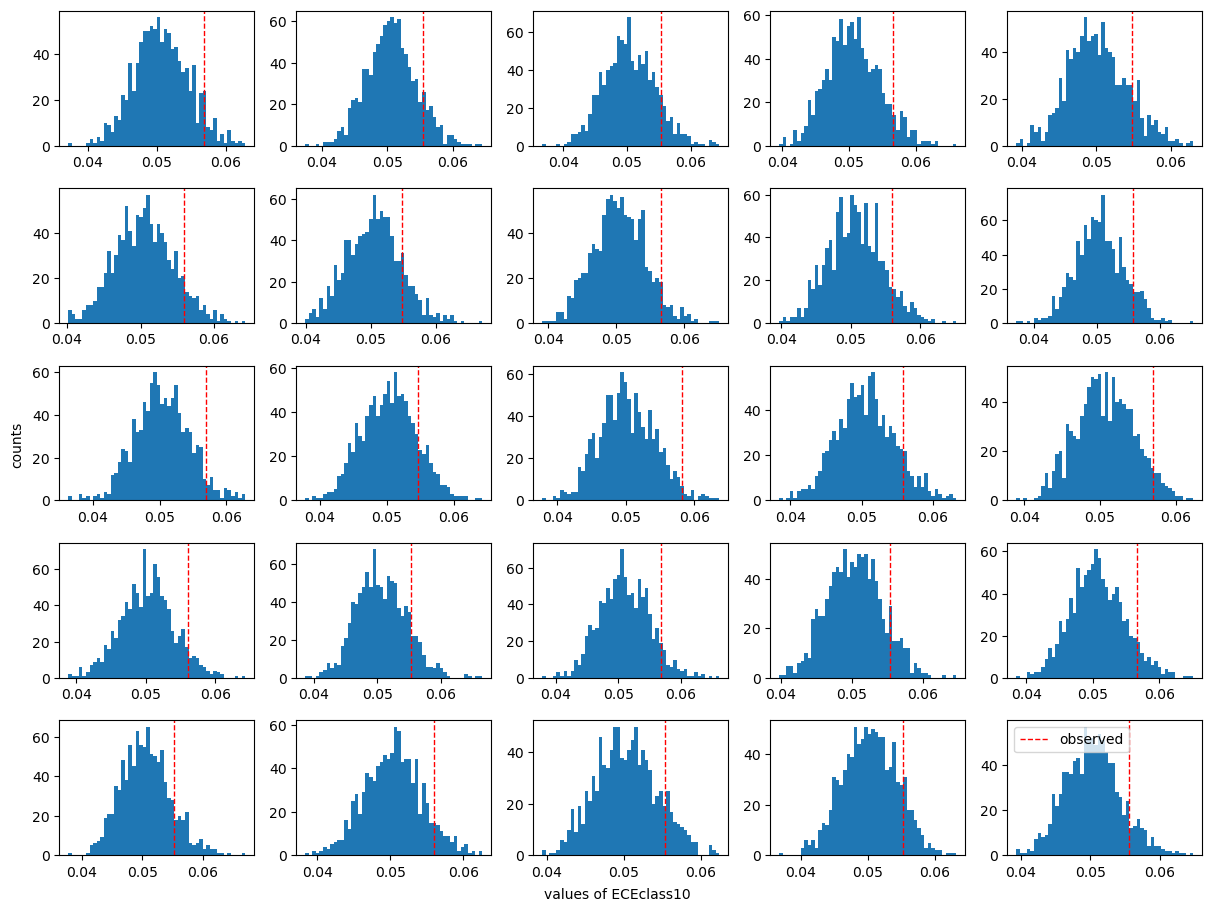

In [ ]:
fig, ax = plt.subplots(5,5, figsize=(12,9),)
count = 0
for i in range(5):
    for j in range(5):
        ax[i,j].hist(stats_h0[count, :], bins=50)
        ax[i,j].axvline(x=stats[count], ymin=0, color='r', linestyle='--', linewidth=1, label="observed")
        count +=1
fig.text(0.5, 0.0, 'values of ECEclass10', ha='center', va='center')
fig.text(0.0, 0.5, 'counts', ha='center', va='center', rotation='vertical')
plt.tight_layout()
plt.legend()

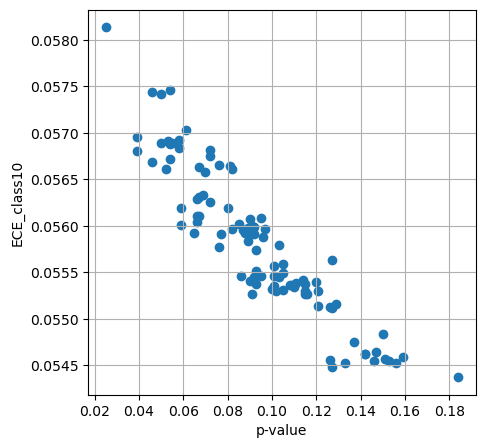

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(p_vals, stats)
ax.set_xlabel("p-value")
ax.set_ylabel("ECE_class10")
plt.grid()

### analyze distributions of miscalibration estimators

In this new setting, for each plot we re-sample the probabilistic predictions of the ensemble members,
and sample the distribution under the null hypothesis for a (randomly sampled) convex combination together
with the minimum value of the test statistic (where the minimum is taken over all possible c.c.'s)

#### 1. classwise ECE

In [ ]:
p_probs, y_labels, weights_l = experiment_h0(N=N_FEATURES, M=N_ENS, K=N_CLASSES, u=U_DIR, l_prior=1, output_weights=True)
min_stat, p_val, stats = npbe_test_p_values(p_probs=p_probs, y_labels=y_labels,
                                                     params=config_p_value_analysis["ECEclass10"]["params"])
obj_val = config_p_value_analysis["ECEclass10"]["params"]["obj_lambda"](weight_l=weights_l, p_probs=p_probs, 
                                                                        y_labels=y_labels,
                                                                        params=config_p_value_analysis["ECEclass10"]["params"])

#### test for setting where $H_0$ is true: 

100%|██████████| 10/10 [01:58<00:00, 11.81s/it]


Text(0.0, 0.5, 'counts')

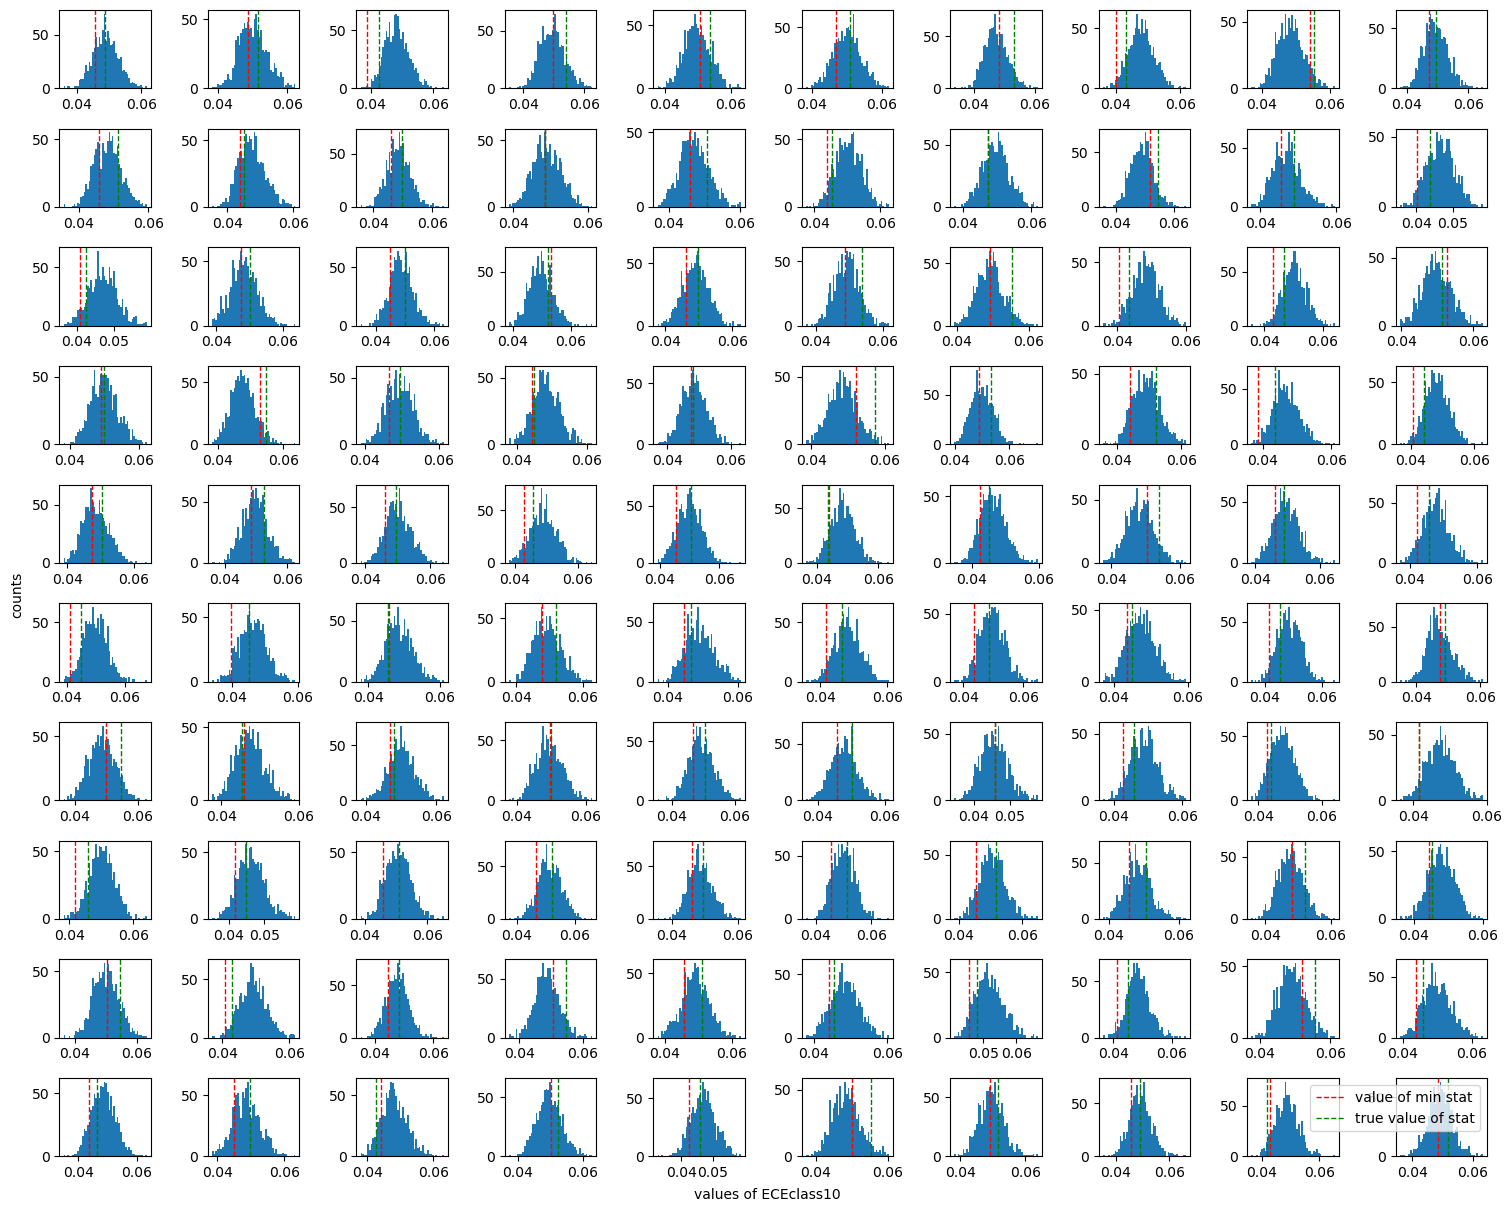

In [ ]:
# save p-values
p_vals = []
# save minimum statistics
min_stats = []
true_stats = []

fig, ax = plt.subplots(10, 10, figsize=(15,12))
for i in range(10):
    for j in tqdm(range(10)):
        p_probs, y_labels, weights_l = experiment_h0(N=100, M=10, K=10, u=0.01, l_prior=10, 
                                                     output_weights=True)
        min_stat, p_val, stats = npbe_test_p_values(p_probs=p_probs, y_labels=y_labels,
                                                     params=config_p_value_analysis["ECEclass10"]["params"])
        p_vals.append(p_val)
        min_stats.append(min_stat)
        ax[i,j].hist(stats, bins=50)
        # check value of "truely calibrated" probabilistic classifier     
        obj_val = config_p_value_analysis["ECEclass10"]["params"]["obj_lambda"](weights_l=weights_l,
                                                                                 p_probs=p_probs, 
                                                                            y_labels=y_labels,
                                                                            params=config_p_value_analysis["ECEclass10"]["params"])
        true_stats.append(obj_val)     
        ax[i,j].axvline(x=min_stat, ymin=0, color='r', linestyle='--', linewidth=1,
                         label="value of min stat")
        ax[i,j].axvline(x=obj_val, ymin=0, color='g', linestyle='--', linewidth=1, 
                        label="true value of stat")
plt.tight_layout()
plt.legend()
fig.text(0.5, 0.0, 'values of ECEclass10', ha='center', va='center')
fig.text(0.0, 0.5, 'counts', ha='center', va='center', rotation='vertical')

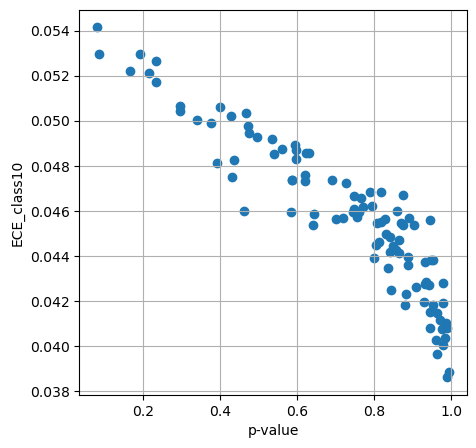

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(p_vals, min_stats)
ax.set_xlabel("p-value")
ax.set_ylabel("ECE_class10")
plt.grid()

(array([ 4.,  7.,  9., 11., 16., 25., 18.,  8.,  1.,  1.]),
 array([-0.00160973, -0.00064229,  0.00032514,  0.00129258,  0.00226001,
         0.00322745,  0.00419488,  0.00516231,  0.00612975,  0.00709718,
         0.00806462]),
 <a list of 10 Patch objects>)

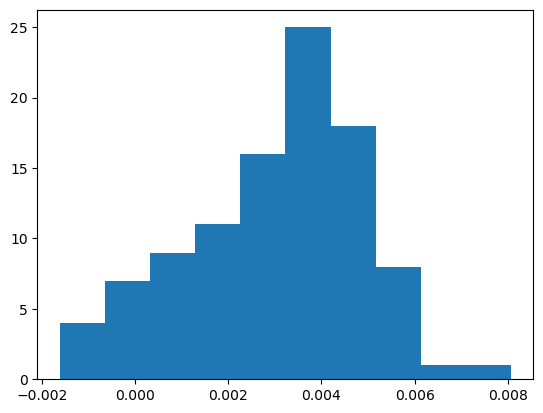

In [ ]:
difs = np.array(true_stats) - np.array(min_stats)
plt.hist(difs)

now for setting where null hypothesis is not true

100%|██████████| 5/5 [01:00<00:00, 12.05s/it]


Text(0.0, 0.5, 'counts')

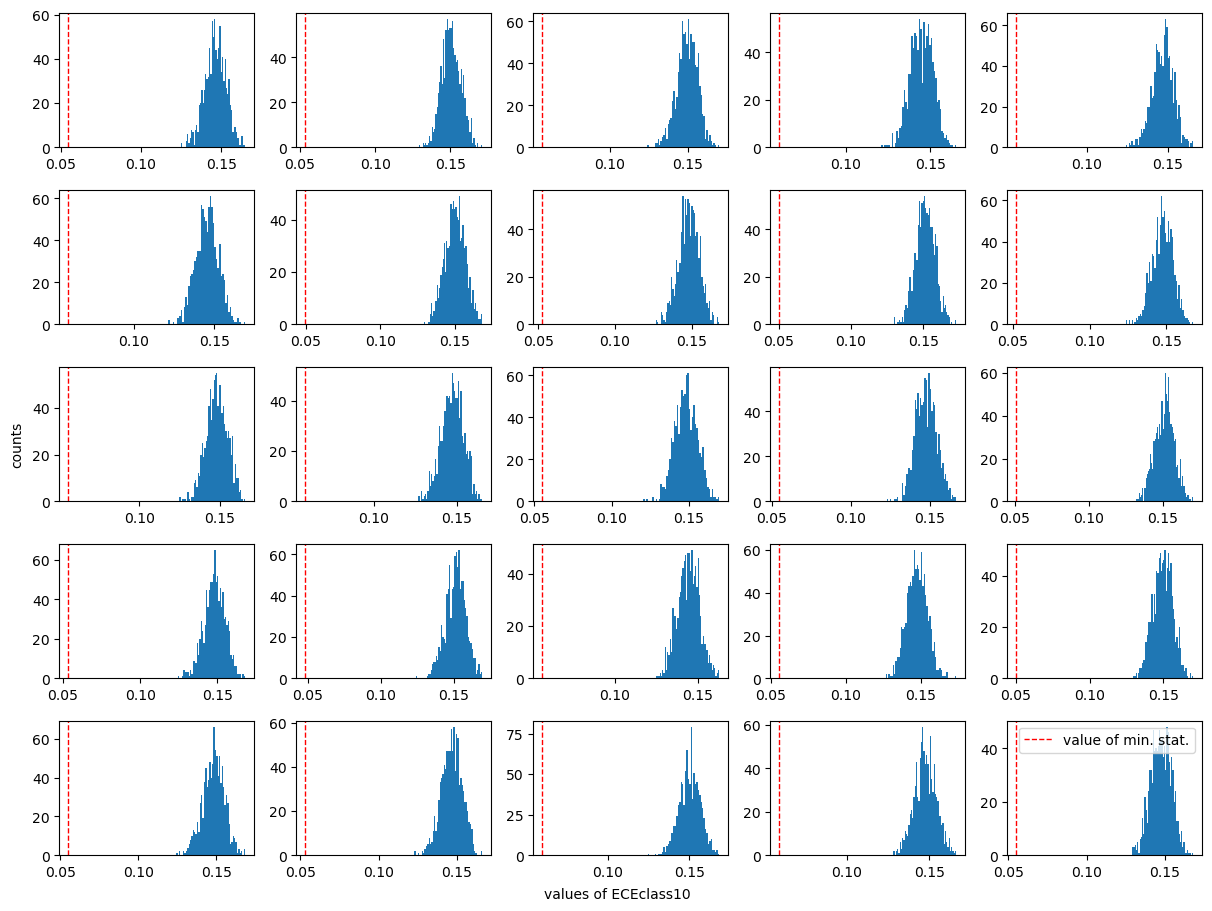

In [ ]:
# save p-values
p_vals = []
# save minimum statistics
min_stats = []

fig, ax = plt.subplots(5, 5, figsize=(12,9))
for i in range(5):
    for j in tqdm(range(5)):
        p_probs, y_labels = experiment_h1(N=100, M=10, K=10, u=0.01)
        min_stat, p_val, stats = npbe_test_p_values(p_probs=p_probs, y_labels=y_labels,
                                                     params=config_p_value_analysis["ECEclass10"]["params"])
        p_vals.append(p_val)
        min_stats.append(min_stat)
        ax[i,j].hist(stats, bins=50)
        ax[i,j].axvline(x=min_stat, ymin=0, color='r', linestyle='--', linewidth=1, 
                        label="value of min. stat.")            
plt.tight_layout()
plt.legend()
fig.text(0.5, 0.0, 'values of ECEclass10', ha='center', va='center')
fig.text(0.0, 0.5, 'counts', ha='center', va='center', rotation='vertical')

#### 2. SKCE

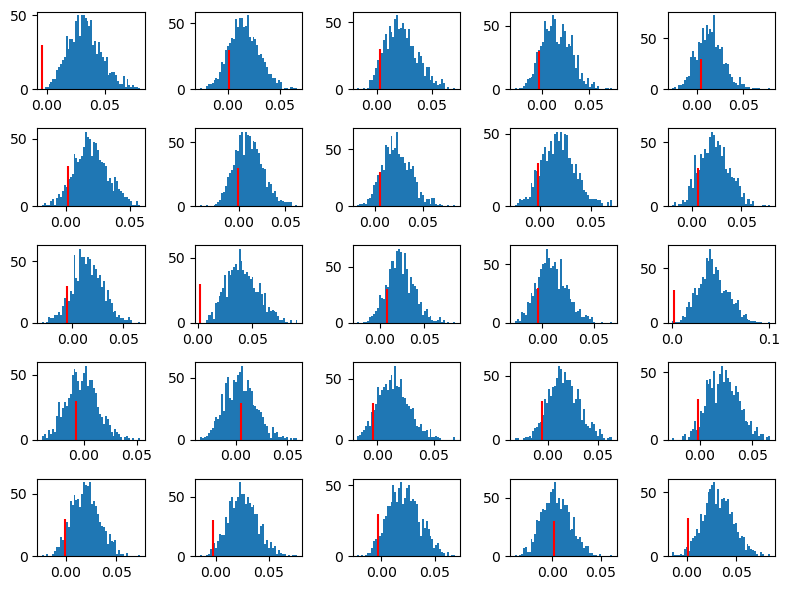

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(8,6))
for i in tqdm(range(5)):
    for j in range(5):
        p_probs, y_labels = experiment_h0(N=100, M=10, K=10, u=0.01, l_prior=10)
        min_stat, p_vals, stats = npbe_test_p_values(p_probs=p_probs, y_labels=y_labels, params=config_p_value_analysis["SKCEul"]["params"])
        ax[i,j].hist(stats, bins=50)
        ax[i,j].axvline(x=min_stat, ymin=0, colors='r', linestyle='--', linewidth=1)
plt.tight_layout()

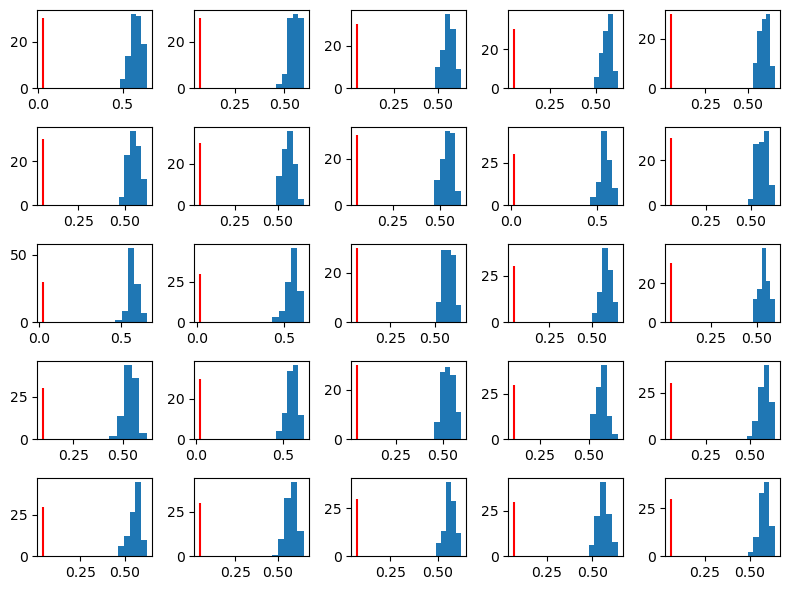

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(8,6))
for i in range(5):
    for j in range(5):
        p_probs, y_labels = experiment_h0(N=100, M=10, K=10, u=0.01, l_prior=10)
        min_stat, p_vals, stats = npbe_test_p_values(p_probs=p_probs, y_labels=y_labels, params=config_p_value_analysis["ECEconf5"]["params"])
        ax[i,j].hist(stats, bins=5)
        ax[i,j].vlines(x=min_stat, ymin=0, ymax=30, colors='r')
plt.tight_layout()

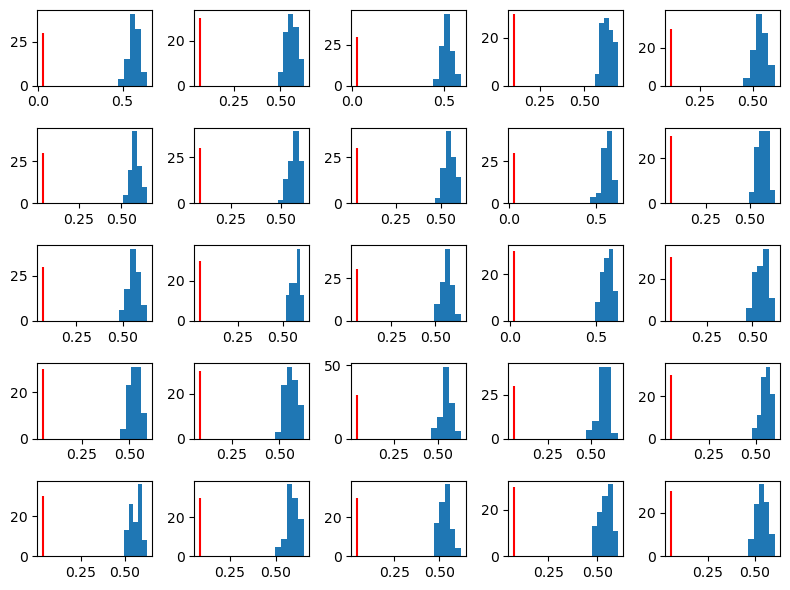

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(8,6))
for i in range(5):
    for j in range(5):
        p_probs, y_labels = experiment_h0(N=100, M=10, K=10, u=0.01, l_prior=10)
        min_stat, p_vals, stats = npbe_test_p_values(p_probs=p_probs, y_labels=y_labels, params=config_p_value_analysis["ECEconf5"]["params"])
        ax[i,j].hist(stats, bins=5)
        ax[i,j].vlines(x=min_stat, ymin=0, ymax=30, colors='r')
plt.tight_layout()

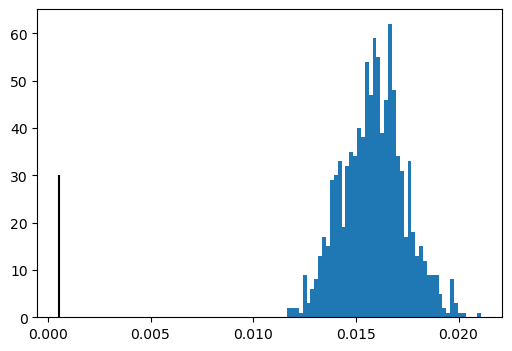

In [ ]:
min_stat, p_vals, stats = npbe_test_p_values(p_probs=p_probs, y_labels=y_labels, params=config_p_value_analysis["SKCEuq"]["params"])

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(stats, bins=50)
ax.vlines(x=min_stat, ymin=0, ymax=30)

### p-value Analysis to visualize correlation between p-value and value of statistic

In [ ]:
result_skceuq = _simulation_pvals(tests=config_p_value_analysis, N=100, M=10, K=10, R=5, u=0.01, experiment=experiment_h0)

  0%|          | 0/5 [00:00<?, ?it/s]


KeyError: 'test'

In [ ]:
result_skceuq

{'SKCEul': array([[ 8.83750422e-03,  2.84251385e-03,  7.49812738e-03,
          8.79483859e-04, -9.53990947e-03],
        [ 4.26000000e-01,  9.68000000e-01,  6.36000000e-01,
          9.20000000e-01,  8.43000000e-01]]),
 'HL5': array([[22.3566091 , 37.91172056, 27.28180728, 16.19859839, 21.80542646],
        [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ]]),
 'HL10': array([[37.70746078, 58.83520921, 47.27653128, 31.86675393, 47.1253145 ],
        [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ]]),
 'ECEconf5': array([[0.01707399, 0.06912498, 0.07252361, 0.0672907 , 0.03688081],
        [1.        , 1.        , 1.        , 1.        , 1.        ]]),
 'ECEconf10': array([[0.02484596, 0.08136251, 0.08355506, 0.11684673, 0.05215653],
        [1.        , 1.        , 1.        , 1.        , 1.        ]]),
 'ECEclass5': array([[0.03359214, 0.04055606, 0.03441673, 0.03739249, 0.04431871],
        [1.        , 1.        , 1.        , 1.        , 1.        ]]

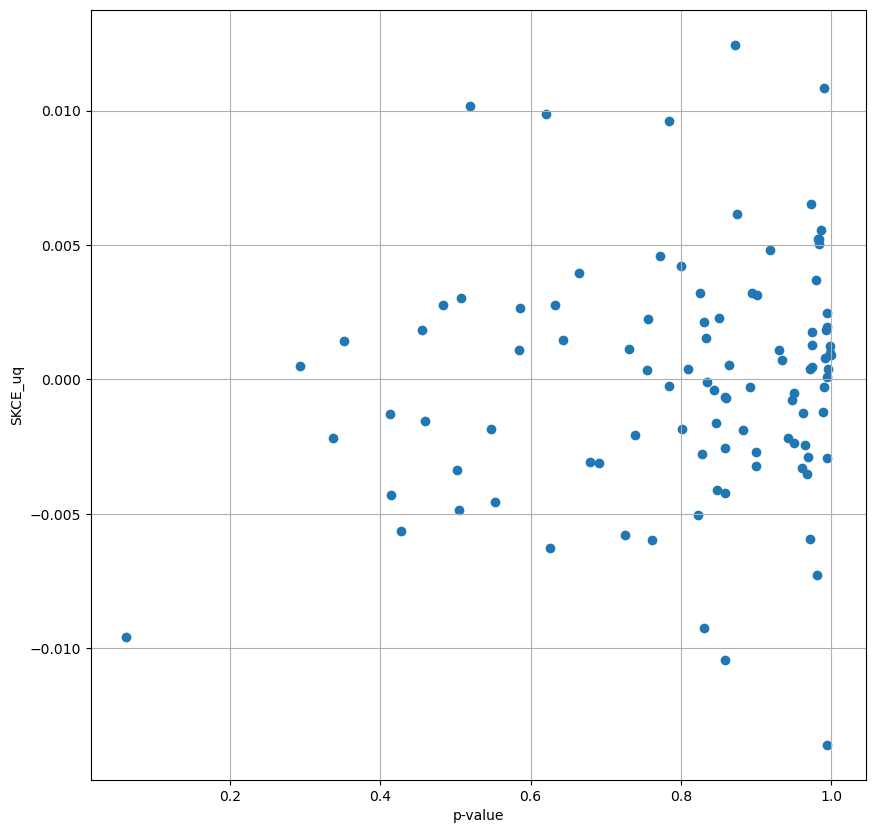

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(result_skceuq[0]["SKCEul"][1, :], result_skceuq[0]["SKCEul"][0, :])
ax.set_xlabel("p-value")
ax.set_ylabel("SKCE_uq")
plt.grid()

